Username: James_MQ

# Code Stub for COMP7220/8220 major project.
Released 17/3/23.
v 1.00

## Frame the Problem

Objective of the task: To classify images into their taxonomical family and classes. There are 8 coarse classes, and 50 fine classes.<br />
Use of Solution: The created model will be used on test data, to predict these two classes.<br />
Type of Problem: It is a supervised learning, classification task.<br />
Performance Measure: The performance measure will be Accuracy.<br />
Data: There are 100K images in the train set, the validation and test sets are 50K each.<br />
Solve problem manually: Would have to open each photo and know the family and class type that it fits into.<br />
Assumptions: That colour in the photo may be helpful when classifying the image, as viewing some train photos there is a lot of noise in each photo.<br />

## Getting the Data - Setting up Base Functions

### Loading the Data and Libraries

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!unzip -q /gdrive/MyDrive/comp8220/living-thing-classification-coarse.zip

In [3]:
!ls -alh public

total 31M
drwxr-xr-x 5 root root 4.0K Jun 15 05:38 .
drwxr-xr-x 1 root root 4.0K Jun 15 05:38 ..
-rw-r--r-- 1 root root 1.3K Mar 11 07:25 info.json
drwxr-xr-x 2 root root 7.0M Jun 15 05:37 test
-rw-r--r-- 1 root root 2.5M Mar 11 07:25 test.csv
drwxr-xr-x 2 root root 7.4M Jun 15 05:38 train
-rw-r--r-- 1 root root 4.8M Mar 11 07:55 train.csv
drwxr-xr-x 2 root root 6.9M Jun 15 05:38 val
-rw-r--r-- 1 root root 2.4M Mar 11 08:35 val.csv


In [4]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from IPython.display import display, Markdown, Latex
import cv2
from skimage.transform import rotate
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from pathlib import Path
import psutil
import time
import gc

print('Libraries have been imported...')

Libraries have been imported...


**Code Summary for Above**

- The above code was mostly supplied by the code stub. I have added the mahatos library as it does some feature creation later on in the code. The library has to be installed on startup of the notebook as it is not standard in colab.

### Set Default Values and Create Re-used Functions

In [5]:
batch_size = 32
img_size = 112
fine_grain = False
num_classes = 50 if fine_grain else 8
root = Path('/content/public')
print('File location is:', root)

tf.random.set_seed(42)
random.seed(42)

File location is: /content/public


In [6]:
def load_target_names(path='public/info.json'):
    with open(path) as f:
        info = json.load(f)
    return info['fine'], info['coarse']

def load_image(file_path, image_size=112):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [image_size, image_size])
    return img

def load_image_cropped(file_path,image_size=112):
    image_size=220
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [image_size, image_size])
    img = tf.image.crop_to_bounding_box(img, 30, 30, 160, 160)
    img = tf.image.resize(img, [img_size, img_size])
    return img

def create_dataset_tf(crop, split, fine_grained, batch_size=32, image_size=112):
  df = pd.read_csv(root / f"{split}.csv")
  file_paths = df.filename.map(lambda fn: str(root / split / fn))
  labels = df.fine if fine_grained else df.coarse

  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  if crop == True:
      dataset = dataset.map(lambda x, y: (load_image_cropped(x, image_size=200), y))
  else:
      dataset = dataset.map(lambda x, y: (load_image(x, image_size=image_size), y))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
  return dataset

def Alt_Dataset_Create_Sklearn(crop, split, fine_grained,percent=0.1):
    batch_s = 100
    dataset = create_dataset_tf(crop, split=split, fine_grained=fine_grained, batch_size=batch_s, image_size=img_size)
    n_batches = int(len(dataset) * percent)
    w = 0
    XX = np.zeros((int(percent*int(len(dataset)*batch_s)),img_size*img_size*3))
    YY = np.zeros((int(percent*int(len(dataset)*batch_s)),))
    for x,y in dataset.take(n_batches):
        x, y = x.numpy(), y.numpy()
        x = x.reshape(x.shape[0], -1)
        XX[w*batch_s:(w+1)*batch_s] = x
        del x
        YY[w*batch_s:(w+1)*batch_s] = y
        del y
        w = w + 1
    return XX, YY


**Code Summary for Above (Basic + Conventional ML Functions)**

- The above code is an adapted version of the code stub as well. For the conventional ML model, since the images had to be resized to be quite small due to RAM constraints, I thought an initial crop and then a resize would be beneficial. It would keep the image quality higher, and the subject of the image tends to be square in the centre of the image, so my assumption was that I would not lose too much information by doing this centre crop.
 - The results of this will be discussed later in the conventional model discussion.
 - The code can also return the images without a centre crop if fed False.
- The other part of the code changed from the stub is how the X and Y arrays are created. Instead of stacking I used an empty numpy array and filled it.
 - This is due to the VStack function seemingly copying the array entirely so you ended up tripling RAM. This way you don't go through that risk, and can put more information in the array to then train the model on.

In [7]:
def augment_image(image, x):
    print(x)
    if x == 0:
        image = tf.image.flip_left_right(image)
    elif x == 1:
        image = tf.image.random_brightness(image, max_delta=0.3)
    elif x == 2:
        image = tf.image.random_saturation(image, 1, 3)
    elif x == 3:
        image = tf.image.random_contrast(image, 0.7, 0.9)
    elif x == 4:
        image = tf.image.central_crop(image, central_fraction=0.75)
        image = tf.image.resize(image, [112, 112])
    else:
        image = tf.image.random_hue(image, 0.15)
    return image

def create_dataset_tfV2(root,split, fine_grained, batch_size=32, image_size=112):
  if root == Path('/content/privtest_coarse'):
        df_name = split+"_coarse"
        print(df_name)
  elif root == Path('/content/privtest_fine'):
        df_name = split+"_fine"
        print(df_name)
  else:
      df_name = split
  df = pd.read_csv(root / f"{df_name}.csv")
  file_paths = df.filename.map(lambda fn: str(root / split / fn))
  labels = df.fine if fine_grained else df.coarse
  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  dataset = dataset.map(lambda x, y: (load_image_cropped(x, image_size=image_size), y))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
  return dataset

def create_dataset_tf_augsV2(root, split, fine_grained, batch_size=32, image_size=112):
    df = pd.read_csv(root / f"{split}.csv")
    file_paths = df.filename.map(lambda fn: str(root / split / fn))
    labels = df.fine if fine_grained else df.coarse

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(lambda x, y: (load_image_cropped(x, image_size=image_size), y))
    augs = [0, 1, 2, 3, 4]
    for i in range(4):
        augmentation = random.randint(0,len(augs)-1)
        augmentation = augs.pop(augmentation)
        ext_dataset = dataset.map(lambda x, y: (augment_image(x, augmentation), y))
        if i == 0:
            other_ds = dataset.concatenate(ext_dataset)
        else:
            other_ds = other_ds.concatenate(ext_dataset)
    other_ds = other_ds.shuffle(buffer_size = 10 * batch_size)
    other_ds = other_ds.batch(batch_size)
    other_ds = other_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return other_ds

def create_dataset_tf_TestTime_augsV1(root, split, fine_grained, aug, batch_size=32, image_size=112):
    if root == Path('/content/privtest_coarse'):
        df_name = split+"_coarse"
        print(df_name)
    elif root == Path('/content/privtest_fine'):
        df_name = split+"_fine"
        print(df_name)
    else:
        df_name = split
    df = pd.read_csv(root / f"{df_name}.csv")
    file_paths = df.filename.map(lambda fn: str(root / split / fn))
    labels = df.fine if fine_grained else df.coarse
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(lambda x, y: (load_image_cropped(x, image_size=image_size), y))
    dataset = dataset.map(lambda x, y: (augment_image(x, aug), y))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

**Code Summary for Above (Deep Learning Functions)**

- The first function gets fed images and returns an augmented image, depending on what number is fed to the function.
- The function called 'create_dataset_tfV2' is the standard dataset grab used for the validation and test sets. It has no augmentation, but does use the centre crop that is standard across the train/val/test sets, so that they are consistent.
- The function called 'create_dataset_tf_augsV2' is used for the train dataset. It is used to grab the train dataset from the google drive and then add some image augmentations to extend the train dataset size. I used this here instead of extra augmentation in the model fitting area.
- The function called 'create_dataset_tf_TestTime_augsV1' is used when doing the final testing on either the test set or the validation set. It is a test time augmentation function which takes the test or val set and changes them to augmented versions of the original images.
 - This is used so that the fine-tuned models can have multiple attempts at predicting the label for the same images (with slight augmentations).

In [8]:
fine_names, coarse_names = load_target_names()
coarse_name_dict = {}
fine_name_dict = {}
for x, name in enumerate(coarse_names):
    coarse_name_dict[x] = name

for x, name in enumerate(fine_names):
    fine_name_dict[x] = name

print(coarse_name_dict)
print(fine_name_dict)

{0: 'Aves', 1: 'Reptilia', 2: 'Mammalia', 3: 'Arachnida', 4: 'Magnoliopsida', 5: 'Insecta', 6: 'Liliopsida', 7: 'Pinopsida'}
{0: 'Scolopacidae', 1: 'Laridae', 2: 'Accipitridae', 3: 'Anatidae', 4: 'Corvidae', 5: 'Icteridae', 6: 'Picidae', 7: 'Colubridae', 8: 'Sciuridae', 9: 'Rosaceae', 10: 'Cyperaceae', 11: 'Brassicaceae', 12: 'Sphingidae', 13: 'Orchidaceae', 14: 'Apidae', 15: 'Papilionidae', 16: 'Orobanchaceae', 17: 'Liliaceae', 18: 'Apocynaceae', 19: 'Poaceae', 20: 'Araneidae', 21: 'Pinaceae', 22: 'Asparagaceae', 23: 'Acrididae', 24: 'Hesperiidae', 25: 'Rubiaceae', 26: 'Onagraceae', 27: 'Libellulidae', 28: 'Fagaceae', 29: 'Cactaceae', 30: 'Lycaenidae', 31: 'Coenagrionidae', 32: 'Boraginaceae', 33: 'Ranunculaceae', 34: 'Polygonaceae', 35: 'Pieridae', 36: 'Caryophyllaceae', 37: 'Lamiaceae', 38: 'Noctuidae', 39: 'Apiaceae', 40: 'Malvaceae', 41: 'Geometridae', 42: 'Plantaginaceae', 43: 'Euphorbiaceae', 44: 'Crambidae', 45: 'Parulidae', 46: 'Erebidae', 47: 'Ericaceae', 48: 'Passerellidae',

**Code Summary for Above**

- This code just grabs the labels to be used during the ML task. Basically the same as the code stub just in a dictionary format.

## Loading, Inspecting and Exploring the Data

Here we want to have a look at the training set images and labels, to get any ideas about what we are working with.<br />
It will also be important here to know how the family labels are grouped under the class labels. May give an idea of how a classification report could improve the accuracy of the model.

### Load the labels and Inspect

In [ ]:
train_df = pd.read_csv(root / f"train.csv")

print(train_df.head())
print(train_df.isnull().sum())

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (28 , 16))
axs1 = sns.countplot(y=train_df['coarse'], ax = axs[0])
axs1.set_yticklabels(coarse_names)
axs1.set_title('Coarse Labels', y = 1.05)

axs2 = sns.countplot(y=train_df['fine'], ax = axs[1])
axs2.set_yticklabels(fine_names)
axs2.set_title('Fine Labels')

plt.show()
del fig, axs1, axs, axs2

**Code Summary for Above**

- This code grabs the train set csv which has the filenames and labels. It then charts the labels for the fine and coarse sets so that I can look at the distribution of classes.

**Take-aways**

- So the train examples are quite skewed on the coarse level but pretty even on the fine level.
- To work with this we may need to get stratified samples and try to augment more examples for the coarse level images that have less instances when training the coarse model
- If this is nature though we don't want to change the weights too much, as that will just drive down accuracy

In [ ]:
grouped = train_df.groupby('coarse')
for group in grouped:
    print(group[0], group[1]['fine'].unique())
del group, train_df, grouped

**Code Summary for Above**

- This code groups the labels between coarse and fine, so that I could see the reason why the coarse level was so skewed.

**Take-aways**

- So this above is telling me that there are multiple fine classes within certain coarse classes.
- This was obvious from the 2 charts, however this could be helpful if building a transfer learning model for the fine label model

### Inspecting Images (Coarse Level Titles)

Now that we have some idea of the distribution of classes in the training set, it will be good to look at some examples of each of the coarse labels, to see if I can come up with any ideas on how to engineer some features, or deal with image augmentation/colouring etc. <br />


In [ ]:
TrainDataPerc = 0.2
X_array = np.zeros((int(TrainDataPerc*100000),img_size*img_size*3+24))
Y_array = np.zeros((int(TrainDataPerc*100000),))

X_array[:int(100000*TrainDataPerc),:img_size*img_size*3], Y_array[:int(100000*TrainDataPerc)] = Alt_Dataset_Create_Sklearn(False, 'train', fine_grained=False, percent = TrainDataPerc)
print(X_array.shape,Y_array.shape)

**Code Summary for Above**

- The above code grabs 20% of the training data, and puts it into two arrays. One being the features and the other being the labels. For this first inspection, I am using the original images without cropping.

In [ ]:
def Viewing_Classes8Egs(class_num):
    display(Markdown('##### Looking at Coarse Class '+str(class_num)+' Images </br>'))
    positions = np.where(Y_array == class_num)[0]
    positions = positions[:9].copy()
    images = X_array[positions].copy()
    plt.figure(figsize = (20 , 6))
    x = 0
    while x < 8:
        ax = plt.subplot(1, 8, x + 1)
        plt.imshow(images[x,:img_size*img_size*3].reshape(img_size,img_size,3))
        if fine_grain:
            plt.title(fine_names[class_num])
        else:
            plt.title(coarse_names[class_num])
        plt.axis("off")
        x = x + 1
    plt.show();
    del positions, images

for i in range(8):
  Viewing_Classes8Egs(i)

**Code Summary for Above**

- The above code then finds the indices of each label and outputs the first 8 photos of each class. This is to allow me to observe some of the photos to get an initial idea of the task.

### Looking at Centre Crop Images (Coarse Level Labels)

In [ ]:
TrainDataPerc = 0.2
X_array = np.zeros((int(TrainDataPerc*100000),img_size*img_size*3+24))
Y_array = np.zeros((int(TrainDataPerc*100000),))

X_array[:int(100000*TrainDataPerc),:img_size*img_size*3], Y_array[:int(100000*TrainDataPerc)] = Alt_Dataset_Create_Sklearn(True, 'train', fine_grained=False, percent = TrainDataPerc)
print(X_array.shape,Y_array.shape)

In [ ]:
for i in range(8):
  Viewing_Classes8Egs(i)

**Code Summary for Above**

- The above code uses the two saved functions from the previous code blocks, however, it feeds the code a True for cropping.

**Take-aways**

- I found from looking at the dimensions of some of the train set photos that they had either a height or width of 256 pixels and a value higher for the other dimension.
- To save RAM space I have to use a 64x64 image, so I found that possibly using an early resize to 220x220 may keep the aspect ratio a bit better than 256x256 immediate resize. Then cropping the outer 15% and resizing the image to 64x64 may help the accuracy.
 - I have found that most of the photos have a lot of background noise so this may help.


### Looking at Colour Channel Distributions

In [ ]:
def GetMean_ColourChannels(class_num):
    positions = np.where(Y_array == class_num)[0]
    images = X_array[positions,:img_size*img_size*3].copy()
    images = images.reshape(len(images),img_size,img_size,3)
    red_values = [np.mean(images[idx][:, :, 0]) for idx in range(len(images))]
    green_values = [np.mean(images[idx][:, :, 1]) for idx in range(len(images))]
    blue_values = [np.mean(images[idx][:, :, 2]) for idx in range(len(images))]
    del images, positions
    return red_values, green_values, blue_values

plt.figure(figsize = (15 , 10))
x = 0
while x < 8:
    ax = plt.subplot(2, 4, x + 1)
    red_values, green_values, blue_values = GetMean_ColourChannels(x)
    plt.hist(red_values, bins = 32, color = 'red', alpha = 0.5)
    plt.hist(green_values, bins = 32, color = 'Green', alpha = 0.5)
    plt.hist(blue_values, bins = 32, color = 'Blue', alpha = 0.5)
    plt.xlabel('Intensity Value')
    plt.ylabel('Count')
    if fine_grain:
        plt.title(fine_names[x])
    else:
        plt.title(coarse_names[x])
    plt.axis("off")
    x = x + 1
plt.show();
del red_values, green_values, blue_values

**Code Summary for Above**

- The above code finds the mean colour channel distributions of the images, for each of the coarse labels. They do not all look the same so I am thinking that keeping the images in colour will be beneficial to the performance of the code.

### Looking at photos with Bilateral Filtering and Canny Edges

In [ ]:
def Viewing_Classes8EgsBiFilter(class_num):
    display(Markdown('##### Looking at Coarse Class '+str(class_num)+' Images </br>'))
    positions = np.where(Y_array == class_num)[0]
    positions = positions[:9].copy()
    images = X_array[positions,:img_size*img_size*3].copy()
    plt.figure(figsize = (20 , 10))
    x = 0
    while x < 8:
        temp_im = images[x].reshape(img_size,img_size,3)
        temp_im = temp_im*255
        img = temp_im.astype(np.uint8)
        median_img = cv2.bilateralFilter(img, 5, 50, 100)
        gray = cv2.cvtColor(median_img, cv2.COLOR_BGR2GRAY)
        edge_img = cv2.Canny(gray, threshold1 = 100, threshold2 = 200)
        ax = plt.subplot(1, 8, x + 1)
        plt.imshow(edge_img)
        if fine_grain:
            plt.title(fine_names[class_num])
        else:
            plt.title(coarse_names[class_num])
        plt.axis("off")
        x = x + 1
    plt.show();
    del positions, images, temp_im, img, median_img

for i in range(8):
    Viewing_Classes8EgsBiFilter(i)

**Code Summary for Above**

- The above code applies a bilateral filtering to the images and then finds their edges using built in functions. I used this to see if the code could pickup obvious shapes of the different animals and plants, however it is obviously not perfect.
 - This was just some extra work trying to figure out ways of grabbing features from the images, to reduce the size of the dataset used for training. This mix looked promising, however say birds and butterflies can look similar here due to their wing shapes.


### Looking at photos with PCA Reduction and Rebuild

In [ ]:
from sklearn.decomposition import PCA

def Viewing_ClassesPCA8Egs(class_num):
    display(Markdown('##### Looking at Coarse Class '+str(class_num)+' Images </br>'))
    positions = np.where(Y_array == class_num)[0]
    positions = positions[:9].copy()
    images = X_array_pca_rec[positions].copy()
    plt.figure(figsize = (20 , 6))
    x = 0
    while x < 8:
        ax = plt.subplot(1, 8, x + 1)
        plt.imshow(images[x,:img_size*img_size*3].reshape(img_size,img_size,3))
        if fine_grain:
            plt.title(fine_names[class_num])
        else:
            plt.title(coarse_names[class_num])
        plt.axis("off")
        x = x + 1
    plt.show();
    del positions, images

pca = PCA(n_components=0.95, random_state=42)
X_array_pca = pca.fit_transform(X_array)
print(pca.n_components_)
X_array_pca_rec = pca.inverse_transform(X_array_pca)

for i in range(8):
  Viewing_ClassesPCA8Egs(i)

**Code Summary for Above**

- The above code applies a PCA decomposition using n = 0.95, which returns back the dimensions that get the data to 95% explainable variance. The code then inverse transforms the images and feeds the inverse transforms to the function which graphs the images.


### Looking at photos with Different Dimensionality Reductions

**Code Summary for Below**

- The below function is from the github attached to the textbook for this unit. It shows how the different labels are grouped after completing the dimensionality reduction (in a 2D plane). The code has been adapted for some differences between the textbook example and the current usage of the code.
<br />

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.04, images=None, figsize=(13, 10)):
    X_normalized = MinMaxScaler().fit_transform(X)
    neighbors = np.array([[10., 10.]])
    plt.figure(figsize=figsize)
    cmap = plt.cm.jet
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1],
                    c=[cmap(float(digit) / 7)], alpha=0.5)
    plt.axis("off")
    ax = plt.gca()  # get current axes
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(float(y[index]) / 7),
                         fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(64, 64)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"),
                                          image_coord)
                ax.add_artist(imagebox)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
%time X_pca_reduced = pca.fit_transform(X_array)
plot_digits(X_pca_reduced, Y_array)
plt.show()

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, random_state=42)
%time X_lle_reduced = lle.fit_transform(X_array)
plot_digits(X_lle_reduced, Y_array)
plt.show()

In [ ]:
from sklearn.decomposition import KernelPCA

KPA = KernelPCA(n_components=2, random_state=42, kernel='rbf')
%time X_kpa_reduced = KPA.fit_transform(X_array)
plot_digits(X_kpa_reduced, Y_array)
plt.show()

In [ ]:
from sklearn.manifold import Isomap

ISO = Isomap(n_components=2)
%time X_iso_reduced = ISO.fit_transform(X_array)
plot_digits(X_iso_reduced, Y_array)
plt.show()

**Take-aways**

- Immediate takeaways is that the LLE method does not seem like a fit here. PCA and Kernel PCA with RBF kernel seem very similar, so it may come down to which is the most time effective here.
- The Isomap method also could be useful, does seem to get a fair amount of the 0 class by themselves, obviously though it is not separated nicely.
- Possibly using a combo and PCA or RBF Kernel with the Isomap could be good, will try that below.

In [ ]:
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca_iso = make_pipeline(PCA(n_components=0.95),
                        Isomap(n_components=2))

%time X_pca_iso_reduced = pca_iso.fit_transform(X_array)
plot_digits(X_pca_iso_reduced, Y_array)
plt.show()

In [ ]:
from sklearn.decomposition import KernelPCA

kpca_iso = make_pipeline(KernelPCA(kernel='rbf', random_state = 42),
                        Isomap(n_components=2))

%time X_kpca_iso_reduced = kpca_iso.fit_transform(X_array)
plot_digits(X_kpca_iso_reduced, Y_array)
plt.show()

**Code Summary for Above**

- The above code applies a PCA reduction followed by an IsoMap reduction, and the second graph shows a KPCA reduction followed by an IsoMap reduction.
 - Both of them seem to work nicely for the 0 class label, and it seems a bit more spread out than the PCA and KPCA by themselves.


### Working with Image Features


The below code creates some basic functions that output some image features. From reading some research papers, some of these techniques were mentioned, however most of the research was talking about more simple or fine grain classification. Never the less, for the conventional model portion of this assignment, some feature creation should help.
<br />

In [ ]:
from skimage.feature import graycomatrix, graycoprops

def Gathering_Zernike_MOMs(class_num):
    display(Markdown('##### Looking at Zernike Moments </br>'))
    positions = np.where(Y_array == class_num)[0]
    positions = positions[:9].copy()
    images = X_array[positions].copy()
    x = 0
    while x < 8:
        temp_im = images[x, :64*64*3].reshape(64,64,3)
        temp_im *= 255
        temp_im = temp_im.astype(np.uint8)
        temp_im = cv2.cvtColor(temp_im, cv2.COLOR_BGR2GRAY)
        values = mt.features.zernike_moments(im = temp_im, radius = 25)
        print(values.shape)
        x = x + 1

def Gathering_GLCM_Features(class_num):
    display(Markdown('##### Looking at GLCM Features </br>'))
    positions = np.where(Y_array == class_num)[0]
    positions = positions[:9]
    images = X_array[positions]

    x = 0
    while x < 8:
        temp_im = images[x, :64*64*3].reshape(64,64,3)
        temp_im *= 255
        temp_im = temp_im.astype(np.uint8)
        temp_im = cv2.cvtColor(temp_im, cv2.COLOR_BGR2GRAY)
        glcm = graycomatrix(temp_im, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0][0]
        energy = graycoprops(glcm, 'energy')[0][0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0][0]
        dissimilarity = graycoprops(glcm, 'dissimilarity')[0][0]
        Corr = graycoprops(glcm, 'correlation')[0][0]
        print(contrast, energy, homogeneity, dissimilarity, Corr)
        x = x + 1

def Gathering_Haralick_Features(class_num):
    display(Markdown('##### Looking at Haralick Features </br>'))
    positions = np.where(Y_array == class_num)[0]
    positions = positions[:9]
    images = X_array[positions]

    x = 0
    while x < 8:
        temp_im = images[x, :64*64*3].reshape(64,64,3)
        temp_im *= 255
        temp_im = temp_im.astype(np.uint8)
        temp_im = cv2.cvtColor(temp_im, cv2.COLOR_BGR2GRAY)
        haralick_features = mt.features.haralick(temp_im)
        haralick_features = haralick_features.mean(axis=0)
        print(haralick_features)
        x = x + 1


def Get_top10row_col(class_num):
    display(Markdown('##### Looking at BG Col </br>'))
    positions = np.where(Y_array == class_num)[0]
    positions = positions[:9]
    images = X_array[positions]
    plt.figure(figsize = (20 , 10))
    x = 0
    while x < 8:
        ax = plt.subplot(1, 8, x + 1)
        temp_im = images[x, :64*64*3].reshape(64,64,3)
        temp_im = temp_im[:10,:,:]
        average_color = np.mean(temp_im, axis=(0, 1)).reshape((1,1,3))
        plt.imshow(average_color)
        plt.axis("off")
        x = x + 1
    plt.show();


for i in range(8):
    print(i)
    Get_top10row_col(i)
    Gathering_GLCM_Features(i)
    Gathering_Haralick_Features(i)
    Gathering_Zernike_MOMs(i)

**Code Summary for Above**

- The code written above is quite simple. Like the previous code blocks it takes the label fed to the function and grabs the first 9 photos for that label. It then completes a calculation and returns the calculated feature.
 - The Get_top10row_col function grabs the first 10 rows of the image and returns the average colour. I thought this would work nicely as for example it could seperate the butterfly and bird images, as the bird images typically have a blue background as the photos are of them in the sky.
 - The Gathering_GLCM_Features function returns basic GLCM features using graycomatrix and graycoprops built in features.
 - The Gathering_Haralick_Features function uses the mahotas library to create haralick features for the images that it is fed. Haralick features help identify textures in images.
 - The Gathering_Zernike_MOMs function does a similar function as the other ones listed above. It uses mathematics of the shapes identified in the images.

### Photo Augmentation Examples

In [ ]:
def Viewing_ClassesAugEgs(class_num):
    display(Markdown('##### Looking at Coarse Class '+str(class_num)+' Images </br>'))
    positions = np.where(Y_array == class_num)[0]
    positions = positions[:9].copy()
    images = X_array[positions].copy()
    plt.figure(figsize = (20 , 10))
    x = 0
    while x < 8:
        temp_im = images[0, :img_size*img_size*3].reshape(img_size,img_size,3)
        ax = plt.subplot(1, 8, x + 1)
        if x == 0:
          temp_im = np.fliplr(temp_im)
        elif x == 1:
          temp_im = np.flipud(temp_im)
        elif x == 2:
          temp_im = rotate(temp_im, angle=45)
        elif x == 3:
          temp_im = rotate(temp_im, angle=-45)
        elif x == 4:
          temp_im = adjust_gamma(temp_im, gamma=0.5,gain=1)
        elif x == 5:
          temp_im = adjust_gamma(temp_im, gamma=2,gain=1)
        elif x == 6:
          temp_im = random_noise(temp_im)
        elif x == 7:
          temp_im = temp_im[int(img_size*0.2):img_size-int(img_size*0.2),int(img_size*0.2):img_size-int(img_size*0.2)]
          temp_im = cv2.resize(temp_im, dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
        plt.imshow(temp_im)
        if fine_grain:
            plt.title(fine_names[class_num])
        else:
            plt.title(coarse_names[class_num])
        plt.axis("off")
        x = x + 1
    plt.show();
    del positions, images, temp_im

for i in range(8):
    Viewing_ClassesAugEgs(i)


**Code Summary for Above**

- The code written above follows a similar format as the other functions in this section of the report in that it takes the images array and makes some changes and then outputs the resulting photos when reshaped from 1D array to 3 channel photo.
- The possible augmentations from above in order are: a left to right flip, a vertical flip, 2 types of rotations, 2 brightness changes, a noise addition and another centre crop.
- The idea is to increase the size of the dataset or even just the smaller class labels, so that the model can train better and perform at a higher accuracy when used on the test set.

## Conventional Model - Preparation, Creation, Fine-Tuning and Discussion

### Conventional Model - Preparing the Data

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.decomposition import PCA
from skimage.feature import graycomatrix, graycoprops

gc.collect()

def Create_Bulk_Features(X_array):
    features = np.zeros((int(len(X_array)),45))
    x = 0
    while x < len(X_array):
        temp_im = X_array[x,:img_size*img_size*3].reshape(64,64,3)
        col_im = temp_im[:10,:,:].copy()
        average_color = np.mean(col_im, axis=(0, 1))
        temp_im *= 255
        temp_im = temp_im.astype(np.uint8)
        temp_im = cv2.cvtColor(temp_im, cv2.COLOR_BGR2GRAY)
        values = mt.features.zernike_moments(im = temp_im, radius = 25)
        haralick_features = mt.features.haralick(temp_im)
        haralick_features = haralick_features.mean(axis=0)
        glcm = graycomatrix(temp_im, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0][0]
        energy = graycoprops(glcm, 'energy')[0][0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0][0]
        dissimilarity = graycoprops(glcm, 'dissimilarity')[0][0]
        Corr = graycoprops(glcm, 'correlation')[0][0]
        colours = np.array([contrast, energy, homogeneity, dissimilarity, Corr])
        total = np.concatenate((values[1:], colours, haralick_features, average_color))
        features[x:x+1] = total
        del col_im, temp_im, values, glcm, contrast, energy, homogeneity, dissimilarity, Corr, haralick_features, colours, total
        x = x + 1
    del X_array, x
    time.sleep(10)
    return features


**Code Summary for Above**

- The code written above imports the libraries used for creating the conventional model, and creating the other models made during testing.
- The Create_Bulk_Features function takes the X_array and returns 45 feature columns for each X_Array row. This is returned and added on to the end of the array from where the function is called.
 - This function just contains the image features discussed in the previous section.

In [ ]:
def Random_Augmentation(image):
    image = image.reshape(img_size,img_size,3)
    augs = [
        lambda x: np.fliplr(x),
        lambda x: np.flipud(x),
        lambda x: rotate(x, angle=5),
        lambda x: rotate(x, angle=-5),
        lambda x: adjust_gamma(x, gamma=0.5,gain=1),
        lambda x: adjust_gamma(x, gamma=2,gain=1),
        lambda x: random_noise(x).astype(np.float32)
    ]
    augmentation = random.choice(augs)
    image = augmentation(image)
    return image.flatten()

def Load_In_Longer_Set(Enlargening_Style, fine_grain):
    TrainDataPerc = 1
    gc.collect()
    print(psutil.virtual_memory()[3]/1000000000)

    train_data = np.memmap("train_data.npy", dtype=np.float32, mode="w+", shape=(int(TrainDataPerc*100000), img_size*img_size*3))
    train_labels = np.memmap("train_labels.npy", dtype=int, mode="w+", shape=(int(TrainDataPerc*100000),))

    train_data[:100000*TrainDataPerc,:img_size*img_size*3], train_labels[:100000*TrainDataPerc] = Alt_Dataset_Create_Sklearn(True,'train', fine_grained=fine_grain, percent = TrainDataPerc)

    train_data.flush()
    train_labels.flush()
    print(psutil.virtual_memory()[3]/1000000000)

    class_count = np.bincount(train_labels)
    max_class_count = np.max(class_count)
    print(class_count)
    print(max_class_count)

    del train_data, train_labels

    time.sleep(20)
    gc.collect()
    time.sleep(5)

    if Enlargening_Style == 'Smoothed':
        tot_length = 0
        for c in class_count:
            if c < 3000:
                tot_length = tot_length + c*7
            elif c < 10000:
                tot_length = tot_length + c*4
            else:
                tot_length = tot_length + c*3
        print('Total length: ',str(tot_length))
    elif Enlargening_Style == 'Balanced' and fine_grain == False:
        tot_length = max_class_count*len(class_count)
    elif Enlargening_Style == 'Balanced' and fine_grain == True:
        tot_length = max_class_count*len(class_count)*4
        print('Total length: ',str(tot_length))

    balanced_data = np.memmap("balanced_data.npy", dtype=np.float32, mode="w+", shape=(int(tot_length), img_size*img_size*3+45))
    balanced_labels = np.memmap("balanced_labels.npy", dtype=int, mode="w+", shape=(int(tot_length),))

    train_data = np.memmap("train_data.npy", dtype=np.float32, mode="r", shape=(int(TrainDataPerc*100000), img_size*img_size*3))
    train_labels = np.memmap("train_labels.npy", dtype=int, mode="r", shape=(int(TrainDataPerc*100000),))

    time.sleep(5)
    print('About to start the photo creation process')
    print(psutil.virtual_memory()[3]/1000000000)

    gc.disable()
    time.sleep(10)
    if Enlargening_Style == 'Balanced' and fine_grain == False:
        aug_lab = None
        for i in range(len(class_count)):
          print('Balancing classes.')
          class_batch = np.zeros((max_class_count,img_size*img_size*3))
          class_indices = np.where(train_labels == i)[0]
          print(class_indices)
          class_batch[:len(class_indices)] = train_data[class_indices]
          x = len(class_indices)
          start = len(class_indices)
          print(i, x)
          while x < max_class_count:
              class_batch[x:x+1] = Random_Augmentation(class_batch[(x-start)])
              x = x + 1
              if x - start > len(class_indices):
                start = start + len(class_indices)
          balanced_data[i*max_class_count:(i+1)*max_class_count, :img_size*img_size*3] = class_batch[:]
          temp_lab = np.repeat(i, max_class_count)
          aug_lab = temp_lab if aug_lab is None else np.hstack([aug_lab, temp_lab])
          time.sleep(5)
          del class_batch, temp_lab
          time.sleep(5)
          balanced_data.flush()
          time.sleep(20)
          print(psutil.virtual_memory()[3]/1000000000)
    elif Enlargening_Style == 'Balanced' and fine_grain == True:
        aug_lab = None
        for i in range(len(class_count)):
          print('Balancing classes.')
          class_batch = np.zeros((max_class_count*4,img_size*img_size*3))
          class_indices = np.where(train_labels == i)[0]
          print(class_indices)
          class_batch[:len(class_indices)] = train_data[class_indices]
          x = len(class_indices)
          start = len(class_indices)
          print(i, x)
          while x < max_class_count*4:
              class_batch[x:x+1] = Random_Augmentation(class_batch[(x-start)])
              x = x + 1
              if x - start > len(class_indices):
                start = start + len(class_indices)
          balanced_data[i*max_class_count*4:(i+1)*max_class_count*4, :img_size*img_size*3] = class_batch[:]
          temp_lab = np.repeat(i, max_class_count*4)
          aug_lab = temp_lab if aug_lab is None else np.hstack([aug_lab, temp_lab])
          time.sleep(5)
          del class_batch, temp_lab
          time.sleep(5)
          balanced_data.flush()
          time.sleep(20)
          print(psutil.virtual_memory()[3]/1000000000)
    elif Enlargening_Style == 'Smoothed':
        print('Performing class extensions and smoothings.')
        aug_lab = None
        overall_count = 0
        for i in range(len(class_count)):
          class_indices = np.where(train_labels == i)[0]
          x = len(class_indices)
          start = len(class_indices)
          max_length = 0
          if start < 3000:
              max_length = start*7
          elif start < 10000:
              max_length = start*4
          else:
              max_length = start*3
          class_batch = np.zeros((max_length,img_size*img_size*3))
          print(class_indices)
          class_batch[:len(class_indices)] = train_data[class_indices]
          print(i, x, max_length)
          while x < max_length:
              class_batch[x:x+1] = Random_Augmentation(class_batch[(x-start)])
              x = x + 1
              if x - start > len(class_indices):
                start = start + len(class_indices)
          balanced_data[overall_count:overall_count + max_length, :img_size*img_size*3] = class_batch[:]
          temp_lab = np.repeat(i, max_length)
          aug_lab = temp_lab if aug_lab is None else np.hstack([aug_lab, temp_lab])
          time.sleep(5)
          overall_count = overall_count + max_length
          print(overall_count)
          del class_batch, temp_lab
          time.sleep(5)
          balanced_data.flush()
          time.sleep(20)
          print(psutil.virtual_memory()[3]/1000000000)

    balanced_labels[:] = aug_lab
    balanced_labels.flush()
    time.sleep(20)
    del train_data, train_labels, class_indices, aug_lab
    gc.enable()
    time.sleep(20)

    print('Photo creation process complete. The feature shape is now: ', str(balanced_data.shape))
    print('We need to shuffle the array though. Completing that via chunking to conserve RAM.')
    shuffled_indices = np.random.permutation(balanced_data.shape[0])
    balanced_data[:] = balanced_data[shuffled_indices]
    balanced_labels[:] = balanced_labels[shuffled_indices]
    balanced_data.flush()
    time.sleep(20)
    balanced_labels.flush()
    time.sleep(20)

    print(psutil.virtual_memory()[3]/1000000000)
    data_shape = balanced_data.shape
    del balanced_data, balanced_labels, shuffled_indices
    time.sleep(20)
    gc.collect()
    print('Balanced Dataset ready. No features, scaling or dimensionality reduction completed yet.')
    return data_shape


def load_In_ValidationSet(fine_grain):
    print('Loading validation set for later')
    TrainDataPerc = 1
    gc.collect()
    print(psutil.virtual_memory()[3]/1000000000)

    val_data = np.memmap("val_data.npy", dtype=np.float32, mode="w+", shape=(int(TrainDataPerc*50000), img_size*img_size*3+45))
    val_labels = np.memmap("val_labels.npy", dtype=int, mode="w+", shape=(int(TrainDataPerc*50000),))

    val_data[:50000*TrainDataPerc,:img_size*img_size*3], val_labels[:50000*TrainDataPerc] = Alt_Dataset_Create_Sklearn(True, 'val', fine_grained=fine_grain, percent = TrainDataPerc)

    val_data.flush()
    time.sleep(5)
    val_labels.flush()
    time.sleep(5)
    print(psutil.virtual_memory()[3]/1000000000)

    del val_data, val_labels
    time.sleep(5)
    gc.collect()
    time.sleep(5)
    print('Finished loading validation set.')
    return

def load_In_TestSet(fine_grain):
    print('Loading Test set for later')
    TrainDataPerc = 1
    gc.collect()
    print(psutil.virtual_memory()[3]/1000000000)

    test_data = np.memmap("test_data.npy", dtype=np.float32, mode="w+", shape=(int(TrainDataPerc*50000), img_size*img_size*3+45))
    test_labels = np.memmap("test_labels.npy", dtype=int, mode="w+", shape=(int(TrainDataPerc*50000),))

    test_data[:50000*TrainDataPerc,:img_size*img_size*3], test_labels[:50000*TrainDataPerc] = Alt_Dataset_Create_Sklearn(True, 'test', fine_grained=fine_grain, percent = TrainDataPerc)

    test_data.flush()
    time.sleep(5)
    test_labels.flush()
    time.sleep(5)
    print(psutil.virtual_memory()[3]/1000000000)

    del test_data, test_labels
    time.sleep(5)
    gc.collect()
    time.sleep(5)
    print('Finished loading validation set.')
    return

random.seed(42)
data_shape = Load_In_Longer_Set('Balanced', True)
load_In_ValidationSet(True)
load_In_TestSet(True)

2.62383616
2.63378944
Total length:  341256
About to start the photo creation process
28.593094656
Performing class extensions and smoothings.
[   13    21    32 ... 99980 99982 99992]
0 20069 60207
60207
2.3717888
[    2    63   252 ... 99895 99911 99916]
1 1891 13237
73444
1.23041792
[   17    38   247 ... 99859 99897 99981]
2 1957 13699
87143
1.236647936
[   16    45    76 ... 99950 99960 99998]
3 2015 14105
101248
1.249841152
[    4     6    11 ... 99995 99997 99999]
4 36062 108186
209434
1.296838656
[    0     3     5 ... 99979 99990 99994]
5 26085 78255
287689
1.3395968
[    1     7     9 ... 99987 99993 99996]
6 9960 39840
327529
1.34064128
[   67   109   143 ... 99922 99948 99989]
7 1961 13727
341256
1.372868608
Photo creation process complete. The feature shape is now:  (341256, 12333)
We need to shuffle the array though. Completing that via chunking to conserve RAM.
1.313677312
Balanced Dataset ready. No features, scaling or dimensionality reduction completed yet.
Loading val

**Code Summary for Above**

The code above is long so I will explain it for each function broken down so you can see why decisions were made to code it in this structure.
- Random_Augmentation: This is a simple function that takes an image and returns a randomly adjusted image as a 1D array. This is used to increase the size of the dataset.

- Load_In_Longer_Set: This function was made to load in the training set, but load it in such a way that the dataset returned was a larger training dataset. The training set was made longer by including augmented images of classes, and I chose to try to make the dataset longer as the models were all overfitting a lot, and PCA was not working in the best way (still overfitting, worse accuracy). The way in which the dataset was lengthened changed over time through testing hence why there are 2 methods - Balanced and Smoothed.
 - The balanced method is different for the coarse and fine datasets as the coarse dataset is so skewed. The coarse dataset just increases the size of the non-largest class label until they are all the same. For fine, all of the classes are increased to 4 x the largest class size. This results in 3 times more images being shown to the model during training, and helps with some of the overfitting.
 - The smoothed method does not go to the extreme of balancing all of the classes, but does increase the overall class weight of the very small classes, so the model has a better chance of learning how to identify these classes.
 - After the dataset is finalised it is saved into the disk via the flush() function, which pushed the changes from RAM to disk. This was key to being able to do any of this dataset manipulation, as the dataset was very large on RAM usage.
- The load_In_ValidationSet and load_In_TestSet functions are much more straight forward.
 - They simply call the main function but store the arrays directly onto the disk using the memmap function from numpy. Again this was key to being able to store the full datasets, instead of having to use a subset.

After running these 3 functions, we have the datasets loaded and saved on the disk, ready for the next step which is adding the features to the images.

In [ ]:
def Create_Features_and_ScalingV2(data_shape):
    balanced_data = np.memmap("balanced_data.npy", dtype=np.float32, mode="r+", shape=data_shape)
    print(balanced_data.shape)

    print('Pre Features')
    print(psutil.virtual_memory()[3]/1000000000)
    feature_batches = int(balanced_data.shape[0]/8)
    gc.disable()
    time.sleep(10)

    for i in range(0, balanced_data.shape[0], feature_batches):
        batch = np.empty((feature_batches, img_size*img_size*3), dtype=np.float32)
        batch[:] = balanced_data[i:i+feature_batches,:img_size*img_size*3].copy()
        balanced_data[i:i+feature_batches, img_size*img_size*3:] = Create_Bulk_Features(batch)
        del batch
        time.sleep(30)
        balanced_data.flush()
        print(str(i), ": ", str(psutil.virtual_memory()[3]/1000000000))
        time.sleep(30)
    gc.enable()
    gc.collect()
    print('Post Features')
    time.sleep(10)

    print('Pre Scaling')
    print(psutil.virtual_memory()[3]/1000000000)
    scaler = MinMaxScaler(copy = False)

    gc.disable()
    time.sleep(10)
    batch = np.empty(balanced_data.shape, dtype=np.float32)
    batch[:] = balanced_data[:].copy()
    balanced_data[:] = scaler.fit_transform(batch)
    balanced_data.flush()
    time.sleep(30)
    print(psutil.virtual_memory()[3]/1000000000)
    del batch
    gc.enable()
    gc.collect()
    time.sleep(20)
    print('Post Scaling')
    print(psutil.virtual_memory()[3]/1000000000)
    del balanced_data
    time.sleep(10)
    print(psutil.virtual_memory()[3]/1000000000)

    #validation set
    print('Train set is ready for testing.\nAdding features to the validation set.')
    val_data = np.memmap("val_data.npy", dtype=np.float32, mode="r+", shape=(50000, img_size*img_size*3+45))
    time.sleep(10)
    feature_batch = np.empty((50000, img_size*img_size*3), dtype=np.float32)
    feature_batch[:] = val_data[:, :img_size*img_size*3].copy()
    val_data[:, img_size*img_size*3:] = Create_Bulk_Features(feature_batch)
    time.sleep(10)
    print(psutil.virtual_memory()[3]/1000000000)
    val_data.flush()
    del feature_batch
    time.sleep(10)
    gc.collect()
    print('Features have been added to validation set. Running scaler on Val.')

    scale_batch = np.empty(val_data.shape, dtype=np.float32)
    scale_batch[:] = val_data[:].copy()
    val_data[:] = scaler.transform(scale_batch)
    time.sleep(10)
    print(psutil.virtual_memory()[3]/1000000000)
    val_data.flush()
    del scale_batch
    time.sleep(10)
    gc.collect()
    print('Validation set has been scaled. Ready for testing.')
    del val_data
    time.sleep(10)

    #test set
    print('Train and validation sets are ready. Adding features and scaling to test set.')
    test_data = np.memmap("test_data.npy", dtype=np.float32, mode="r+", shape=(50000, img_size*img_size*3+45))
    time.sleep(10)
    feature_batch = np.empty((50000, img_size*img_size*3), dtype=np.float32)
    feature_batch[:] = test_data[:, :img_size*img_size*3].copy()
    test_data[:, img_size*img_size*3:] = Create_Bulk_Features(feature_batch)
    time.sleep(10)
    print(psutil.virtual_memory()[3]/1000000000)
    test_data.flush()
    del feature_batch
    time.sleep(10)
    gc.collect()
    print('Features have been added to test set. Running scaler on Val.')

    scale_batch = np.empty(test_data.shape, dtype=np.float32)
    scale_batch[:] = test_data[:].copy()
    test_data[:] = scaler.transform(scale_batch)
    time.sleep(10)
    print(psutil.virtual_memory()[3]/1000000000)
    test_data.flush()
    del scale_batch, scaler
    time.sleep(10)
    gc.collect()
    print('Test set has been scaled. Ready for testing.')
    del test_data
    time.sleep(10)
    return

Create_Features_and_ScalingV2(data_shape)

(341256, 12333)
Pre Features
1.3710336
0 :  1.347649536
42657 :  1.381097472
85314 :  1.346064384
127971 :  1.324822528
170628 :  1.334153216
213285 :  1.344294912
255942 :  1.33384192
298599 :  1.284313088
Post Features
Pre Scaling
1.277202432
18.220965888
Post Scaling
1.380524032
1.30625536
Train set is ready for testing.
Adding features to the validation set.
3.774554112
Features have been added to validation set. Running scaler on Val.
3.77278464
Validation set has been scaled. Ready for testing.
Train and validation sets are ready. Adding features and scaling to test set.
3.780235264
Features have been added to validation set. Running scaler on Val.
39.89833728
Test set has been scaled. Ready for testing.


**Code Summary for Above**

- The above code is used to create features and use a minmax scaler on the train, validation and test sets. They are all included in the same function call so that the same features and scaler can be used on all of the datasets for reliability. I have also included print statements throughout the function so I can know where it is up to when running it.
 - For the train set a batching process is used so that RAM is not all used at once. For the validation and test set, RAM is not as big of an issue so they can have their features all made at once.
 - This process can take a fair while (around 2hrs) so it is important that the changes are flushed to the disk to avoid the RAM being overloaded and causing the whole process to be restarted.
- After this function has finished, the data is ready to be used on models.

In [ ]:
def Save_Arrays_toGDRIVE(fine_grain):
    print('Saving featured and scaled arrays to google drive.')
    balanced_data = np.memmap("balanced_data.npy", dtype=np.float32, mode="r", shape=data_shape)
    balanced_labels = np.memmap("balanced_labels.npy", dtype=int, mode="r", shape=(data_shape[0],))

    bal_train_feat_name = "/gdrive/MyDrive/comp8220/balanced_train_data_FINE.npy" if fine_grain else "/gdrive/MyDrive/comp8220/balanced_train_data.npy"
    bal_train_lab_name = "/gdrive/MyDrive/comp8220/balanced_train_labels_FINE.npy" if fine_grain else "/gdrive/MyDrive/comp8220/balanced_train_labels.npy"

    test_data_feat = "/gdrive/MyDrive/comp8220/test_featured_data_FINE.npy" if fine_grain else"/gdrive/MyDrive/comp8220/test_featured_data.npy"

    val_data_feat = "/gdrive/MyDrive/comp8220/val_featured_data_FINE.npy" if fine_grain else "/gdrive/MyDrive/comp8220/val_featured_data.npy"
    val_data_label =  "/gdrive/MyDrive/comp8220/val_featured_labels_FINE.npy" if fine_grain else "/gdrive/MyDrive/comp8220/val_featured_labels.npy"

    np.save(bal_train_feat_name, balanced_data)
    time.sleep(30)
    np.save(bal_train_lab_name, balanced_labels)
    time.sleep(30)

    test_data = np.memmap("test_data.npy", dtype=np.float32, mode="r", shape=(50000, img_size*img_size*3+45))
    np.save(test_data_feat, test_data)
    time.sleep(30)

    val_data = np.memmap("val_data.npy", dtype=np.float32, mode="r", shape=(50000, img_size*img_size*3+45))
    np.save(val_data_feat, val_data)
    time.sleep(30)
    val_labels = np.memmap("val_labels.npy", dtype=int, mode="r", shape=(50000,))
    np.save(val_data_label, val_labels)

    time.sleep(30)
    del val_labels, val_data, test_data, balanced_labels, balanced_data
    print('Done.')
    return

Save_Arrays_toGDRIVE(fine_grain)

**Code Summary for Above**

- The above code was used to save the memmap arrays to google drive. This was needed for when I was testing various models over and over, and if they broke or caused the RAM to run out I would have to load in the memory again. This gets rid of that issue for testing models


### Conventional Model - Creating Models and Defining Functions for Testing

In [ ]:
def Train_Test_Model_onVal(model, fine_grain):
    bal_data_name = "/gdrive/MyDrive/comp8220/balanced_train_data_FINE.npy" if fine_grain else "/gdrive/MyDrive/comp8220/balanced_train_data.npy"
    bal_lab_name = "/gdrive/MyDrive/comp8220/balanced_train_labels_FINE.npy" if fine_grain else "/gdrive/MyDrive/comp8220/balanced_train_labels.npy"

    balanced_data = np.load(bal_data_name, mmap_mode='r')
    balanced_labels = np.load(bal_lab_name, mmap_mode='r')

    print(psutil.virtual_memory()[3]/1000000000)
    print('Fitting the model on the train dataset.')
    model.fit(balanced_data,balanced_labels)

    time.sleep(10)
    print('Making predictions and scoring model on train set.')
    train_preds = model.predict(balanced_data)
    train_score = accuracy_score(balanced_labels, train_preds)
    display(Markdown('**Classification Report**'))
    print(classification_report(balanced_labels, train_preds))

    print(psutil.virtual_memory()[3]/1000000000)
    print('The train accuracy score is:', str(train_score))
    del train_preds, train_score, balanced_data, balanced_labels
    gc.collect()
    time.sleep(10)

    val_data_feat = "/gdrive/MyDrive/comp8220/val_featured_data_FINE.npy" if fine_grain else "/gdrive/MyDrive/comp8220/val_featured_data.npy"
    val_data_label =  "/gdrive/MyDrive/comp8220/val_featured_labels_FINE.npy" if fine_grain else "/gdrive/MyDrive/comp8220/val_featured_labels.npy"

    val_data = np.load(val_data_feat, mmap_mode='r')
    val_labels = np.load(val_data_label, mmap_mode='r')

    print(psutil.virtual_memory()[3]/1000000000)

    print('Now fitting the model to the validation set.')
    y_pred = model.predict(val_data)
    print('Model predicted on val set and achieved accuracy of ', str(accuracy_score(val_labels, y_pred)))
    fig, ax = plt.subplots(figsize = (12 , 9))
    DT_Conf_Matrix = confusion_matrix(val_labels, y_pred)
    ax = sns.heatmap(DT_Conf_Matrix, annot = True, cmap='coolwarm')
    ax.set_title(label = 'Model', fontdict = {'fontweight' : 'bold'})
    ax.set_ylabel('Actual Classes')
    ax.set_xlabel('Predicted Classes')
    plt.show()
    display(Markdown('**Classification Report**'))
    print(classification_report(val_labels, y_pred))

    del fig, ax
    del val_data, val_labels, DT_Conf_Matrix, model
    time.sleep(10)
    return y_pred

def Manual_Ensemble_vsVal(manual_pred_array, fine_grain):
    val_data_label =  "/gdrive/MyDrive/comp8220/val_featured_labels_FINE.npy" if fine_grain else "/gdrive/MyDrive/comp8220/val_featured_labels.npy"
    val_labels = np.load(val_data_label, mmap_mode='r')
    print('Model predicted on val set and achieved accuracy of ', str(accuracy_score(val_labels, manual_pred_array)))

    fig, ax = plt.subplots(figsize = (12 , 9))
    DT_Conf_Matrix = confusion_matrix(val_labels, manual_pred_array)
    ax = sns.heatmap(DT_Conf_Matrix, annot = True, cmap='coolwarm')
    ax.set_title(label = 'Model', fontdict = {'fontweight' : 'bold'})
    ax.set_ylabel('Actual Classes')
    ax.set_xlabel('Predicted Classes')
    plt.show()
    display(Markdown('**Classification Report**'))
    print(classification_report(val_labels, manual_pred_array))

    del val_labels, manual_pred_array, fig, ax
    return

**Code Summary for Above**

- The function Train_Test_Model_onVal is fed a model, and then the model is fit on the train dataset that was saved on the google drive in the previous section. It is then scored on the train set and the validation set so that I can tell if the model is overfitting/underfitting. It also returns a confusion matrix so that I can tell what the model is not performing well on.
- The function Manual_Ensemble_vsVal takes predictions and returns the score against the validation set as well as providing a confusion matrix. It is similar to the other function but for testing ensemble performance.

In [ ]:
def Save_Test_Preds(preds, pred_name, fine_grain):
    test_csv = pd.read_csv(root / f"test.csv")
    if fine_grain == False:
        test_csv.loc[:,"coarse"] = preds
        test_csv = test_csv.drop(columns=['fine'])
    else:
        test_csv.loc[:,"fine"] = preds
        test_csv = test_csv.drop(columns=['coarse'])
    pred_file = "/gdrive/MyDrive/comp8220/44900333_CONV_"+pred_name+".csv"
    test_csv.to_csv(pred_file, index=False)
    print('Pushed test predictions to gdrive')
    del test_csv, pred_file, preds
    return

def Save_Val_Preds(preds, pred_name, fine_grain):
    val_csv = pd.read_csv(root / f"val.csv")
    if fine_grain == False:
        val_csv.loc[:,"coarse"] = preds
        val_csv = val_csv.drop(columns=['fine'])
    else:
        val_csv.loc[:,"fine"] = preds
        val_csv = val_csv.drop(columns=['coarse'])
    pred_file = "/gdrive/MyDrive/comp8220/44900333_CONV_"+pred_name+".csv"
    val_csv.to_csv(pred_file, index=False)
    print('Pushed validation predictions to gdrive')
    del val_csv, pred_file, preds
    return

**Code Summary for Above**

- The above functions are pretty straight forward. They just take the predictions generated from the function: Train_Test_Model_onVal, and then save those predictions so that they can be used in ensemble testing or on the Kaggle competition.

In [ ]:
def Final_Predictions_onTest_Set(model, combo_shape, fine_grain):
    print(combo_shape)
    combo_train = np.memmap("combo_train.npy", dtype=np.float32, mode="r", shape=combo_shape)
    combo_labels = np.memmap("combo_labels.npy", dtype=int, mode="r", shape=(combo_shape[0],))

    print(psutil.virtual_memory()[3]/1000000000)
    print('Fitting the model on the train dataset.')
    model.fit(combo_train,combo_labels)

    time.sleep(10)
    print('Making predictions and scoring model on train set.')
    train_preds = model.predict(combo_train)
    train_score = accuracy_score(combo_labels, train_preds)
    display(Markdown('**Classification Report**'))
    print(classification_report(combo_labels, train_preds))

    print(psutil.virtual_memory()[3]/1000000000)
    print('The train accuracy score is:', str(train_score))
    del train_preds, train_score, combo_train, combo_labels
    gc.collect()
    time.sleep(10)

    test_data_feat = "/gdrive/MyDrive/comp8220/test_featured_data_FINE.npy" if fine_grain else"/gdrive/MyDrive/comp8220/test_featured_data.npy"

    test_data = np.load(test_data_feat, mmap_mode='r')
    print(psutil.virtual_memory()[3]/1000000000)

    print('Now fitting the model to the test set.')
    y_pred = model.predict(test_data)
    return y_pred


def Create_Final_TrainSet(fine_grain):
    val_data_feat = "/gdrive/MyDrive/comp8220/val_featured_data_FINE.npy" if fine_grain else "/gdrive/MyDrive/comp8220/val_featured_data.npy"
    val_data_label =  "/gdrive/MyDrive/comp8220/val_featured_labels_FINE.npy" if fine_grain else "/gdrive/MyDrive/comp8220/val_featured_labels.npy"

    val_data = np.load(val_data_feat, mmap_mode='r')
    val_labels = np.load(val_data_label, mmap_mode='r')

    bal_data_name = "/gdrive/MyDrive/comp8220/balanced_train_data_FINE.npy" if fine_grain else "/gdrive/MyDrive/comp8220/balanced_train_data.npy"
    bal_lab_name = "/gdrive/MyDrive/comp8220/balanced_train_labels_FINE.npy" if fine_grain else "/gdrive/MyDrive/comp8220/balanced_train_labels.npy"

    balanced_data = np.load(bal_data_name, mmap_mode='r')
    balanced_labels = np.load(bal_lab_name, mmap_mode='r')

    data_shape = balanced_data.shape
    print(data_shape)
    combo_train = np.memmap("combo_train.npy", dtype=np.float32, mode="w+", shape=(int(50000+data_shape[0]), img_size*img_size*3+45))
    combo_labels = np.memmap("combo_labels.npy", dtype=int, mode="w+", shape=(int(50000+data_shape[0]),))
    combo_shape = combo_train.shape
    print(combo_shape)

    combo_train[:50000] = val_data[:]
    del val_data
    combo_train.flush()
    time.sleep(10)

    combo_train[50000:] = balanced_data[:]
    del balanced_data
    combo_train.flush()
    time.sleep(10)

    del combo_train
    print('Features combined.')
    time.sleep(10)

    combo_labels[:50000] = val_labels[:]
    del val_labels
    combo_labels.flush()
    time.sleep(10)

    combo_labels[50000:] = balanced_labels[:]
    del balanced_labels
    combo_labels.flush()
    time.sleep(10)

    del combo_labels
    print('Labels combined.')
    time.sleep(10)
    print('Training set ready for final set.')
    return combo_shape

**Code Summary for Above**

- The above function: Create_Final_TrainSet, takes the fine_grain binary and creates a combined validation and train dataset to train the model on. The function returns the shape as that is needed when working with memmap arrays.
- The other function: Final_Predictions_onTest_Set, trains the model on the combined train and validation set. It then provides an accuracy score on the combined set and returns a prediction for the public test set. This test set prediction can be fed to the Save_Test_Preds function to be pushed through to the google drive for storage

In [ ]:
lgb_clf_none = lgb.LGBMClassifier(objective = 'multiclass', random_state = 42, num_class=8, min_split_gain=1e-05, max_depth=10, learning_rate = 0.1, num_leaves = 60,
                                  class_weight = None, n_estimators = 200, n_jobs = -1, metric = 'multi_logloss')
combo_shape = Create_Final_TrainSet(fine_grain)
lgb_clf_none_preds = Final_Predictions_onTest_Set(lgb_clf_none, combo_shape, fine_grain)
Save_Test_Preds(lgb_clf_none_preds, "LGB_TESTSET1505", fine_grain)
del lgb_clf_none
#Note this model scored 0.59531 on the test set once uploaded, which is very similar to the validation set. This was with no PCA. On the smoothed and train on val sets.

(341256, 12333)
(391256, 12333)
Features combined.
Labels combined.
Training set ready for final set.
(391256, 12333)
2.12813824
Fitting the model on the train dataset.
Making predictions and scoring model on train set.


**Classification Report**

              precision    recall  f1-score   support

           0       0.77      0.74      0.75     70142
           1       0.98      0.71      0.82     14286
           2       0.99      0.67      0.80     14692
           3       0.98      0.63      0.76     15033
           4       0.64      0.90      0.75    126155
           5       0.71      0.74      0.73     91261
           6       0.97      0.25      0.39     44915
           7       0.94      0.72      0.82     14772

    accuracy                           0.73    391256
   macro avg       0.87      0.67      0.73    391256
weighted avg       0.77      0.73      0.71    391256

41.568436224
The train accuracy score is: 0.7271530660232687
41.588760576
Now fitting the model to the test set.


**Code Summary for Above**

- The above code is what was used to get my best accuracy score on the coarse public test set when working with conventional ML models. Its performance and the performance of the other conventional ML models will be discussed further down, however this block is just to show the process of creating a model, training it and creating the test predictions

2.725781504
Fitting the model on the train dataset.
Making predictions and scoring model on train set.


**Classification Report**

              precision    recall  f1-score   support

           0       0.76      0.89      0.82      8276
           1       0.78      0.91      0.84      8276
           2       0.70      0.84      0.76      8276
           3       0.94      0.88      0.90      8276
           4       0.99      0.82      0.90      8276
           5       0.97      0.83      0.90      8276
           6       0.92      0.88      0.90      8276
           7       0.94      0.94      0.94      8276
           8       0.93      0.91      0.92      8276
           9       0.98      0.93      0.95      8276
          10       0.86      0.93      0.89      8276
          11       0.98      0.94      0.96      8276
          12       0.99      0.91      0.95      8276
          13       0.99      0.93      0.96      8276
          14       0.95      0.93      0.94      8276
          15       0.89      0.92      0.91      8276
          16       0.88      0.95      0.92      8276
          17       0.99    

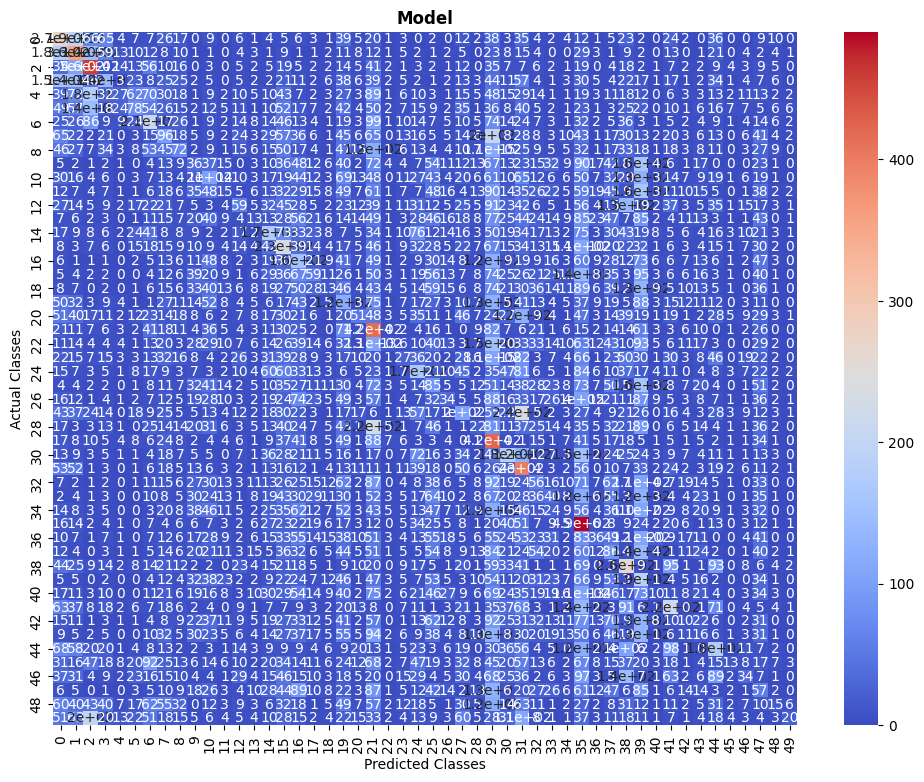

**Classification Report**

              precision    recall  f1-score   support

           0       0.15      0.27      0.19       981
           1       0.21      0.36      0.27       997
           2       0.29      0.47      0.36       981
           3       0.19      0.14      0.16       998
           4       0.16      0.03      0.05      1003
           5       0.17      0.08      0.11       979
           6       0.19      0.22      0.20       967
           7       0.10      0.09      0.09      1049
           8       0.13      0.07      0.09       993
           9       0.05      0.04      0.04       991
          10       0.10      0.10      0.10      1045
          11       0.05      0.01      0.02      1049
          12       0.13      0.06      0.08       991
          13       0.06      0.01      0.02       978
          14       0.17      0.17      0.17      1025
          15       0.13      0.22      0.16      1031
          16       0.09      0.16      0.12       956
          17       0.11    

In [ ]:
rf_clf_20_none = RandomForestClassifier(random_state = 42, n_jobs = -1, class_weight = None, max_depth=20, min_samples_leaf=15, min_samples_split=30, n_estimators=500)
rf_preds = Train_Test_Model_onVal(rf_clf_20_none, fine_grain)
del rf_clf_20_none
Save_Val_Preds(rf_preds, 'RF_VALSET_20dep', fine_grain)
del rf_preds

**Code Summary for Above**

- The above code can be used to get a test prediction for the RF model, which had the best performance on the validation dataset with the fine labels.
- I ran out of time to submit a prediction for the fine model on the test set, however this performed slightly better than the ensembles below did on the validation set.

In [ ]:
import itertools

def Combo_Val_Models():
    ext_15 = pd.read_csv("/gdrive/MyDrive/comp8220/44900333_CONV_EXT_VALSET_15DEP_FINE.csv", usecols=["fine"])
    ext_15 = ext_15.rename(columns={'fine': 'ext_15'})
    LBG = pd.read_csv("/gdrive/MyDrive/comp8220/44900333_CONV_LGB_VALSET_FINE.csv", usecols=["fine"])
    LBG = LBG.rename(columns={'fine': 'LBG'})
    MLP = pd.read_csv("/gdrive/MyDrive/comp8220/44900333_CONV_MLP_VALSET_50ITS_FINE.csv", usecols=["fine"])
    MLP = MLP.rename(columns={'fine': 'MLP'})
    RF = pd.read_csv("/gdrive/MyDrive/comp8220/44900333_CONV_RF_VALSET_20dep_FINE.csv", usecols=["fine"])
    RF = RF.rename(columns={'fine': 'RF'})

    models = [ext_15, LBG, MLP, RF]
    indexes = [0,1,2,3]
    models_combos = []
    for x in range(3, len(indexes) + 1):
        for subset in itertools.combinations(indexes, x):
            models_combos.append(subset)
    print(models_combos)
    print(len(models_combos))

    for combo in models_combos:
        df = LBG
        for y, x in enumerate(combo):
            if y == 0:
                df = models[x]
            else:
                df = pd.merge(df, models[x], left_index=True, right_index=True)
        print(df)
        modes = []
        for index, row in df.iterrows():
            mode = row.mode()
            modes.append(mode[0])
        print(np.bincount(modes))
        Manual_Ensemble_vsVal(modes, True)
        print('combo end')
    return

Combo_Val_Models()

Output hidden; open in https://colab.research.google.com to view.

**Code Summary for Above**

- The above code was used to assess the fine dataset conventional models in different ensembles. Since the models all performed quite poorly I thought the use of an ensemble would be beneficial in this scenario. However, it did not really add much value as the best model ensemble performance was around the same as the RF model was. More discussion on the results is below.

### Conventional Model - Discussion and Future Improvements/Ideas

**Overall Results - Conventional**

The conventional model used after training, comparisons and fine-tuning on the coarse dataset was the LGB model, and the model that scored the best on the validation dataset with fine classes was the random forest model.
- LGB model: parameters: max_depth=10, learning_rate = 0.1, num_leaves = 60, n_estimators = 200.
- Coarse (LGB):
  - Validation Accuracy: 0.5891
  - Public Test Accuracy: 0.59531
- RF model: max_depth=20, min_samples_leaf=15, min_samples_split=30, n_estimators=500.
- Fine (RF):
  - Validation Accuracy: 0.12654
  - Public Test Accuracy: Ran out of time to test this.

The LGB model performed significantly better than the other models on the coarse labels, despite all of the models overfitting and mainly predicting classes 0, 4 and 5. On the fine classes, the RF model performed better than the other models, and also better than the ensemble which can be seen in the above sections' code.<br>


<br>**Process and Further Discussion - (Coarse Labels) Conventional ML**

As discussed between the code blocks above, a major challenge of the task was fitting the data into RAM, to be able to train the models. Therefore, originally I was not using Memmap arrays, and just using the 64 pixel RGB photos. I was also increasing the dataset size by adding 1 image augmentation each to extend the dataset to 200K images.
- During this time the models were scoring as per below:
  - Random Forest: Validation accuracy of 0.50906
  - Extra Trees: 0.5067
  - MLP Classifier: 0.5276
- Note: the RF and Extra Trees (EXT) classifiers were heavily overfitting with training accuracy around 90%. The MLP classifier had a training accuracy around 52%, however, it took very long to train any longer and would not improve much no matter what the n_estimators was changed to.<br>

<br>To address this overfitting I used random gridsearch to see if I was setting the hyperparameters poorly, and also tested a LGB model and a KNN model.
- The LGB model scored 0.57365 on the validation set with a training accuracy around 80%. This was significantly less overfitting and a significantly better accuracy score than the other models.
- The KNN scored 0.31307 on the validation set. It was only classifying images as class 0 or 5, no matter what the random search used for the neighbours and distance calcs, so I stopped using this model.
- The random search improved the RF model to 0.515 and the EXT model to 0.50833.<br>

<br>Next I tried using a totally balanced dataset, and then a PCA on the dataset with 0.95, so that 95% of the variance was explained. Both of these ideas made accuracy worse, and since that was the ultimate task I decided not to proceed with these methods.
- LGB scored 0.84355 on the balanced train set, and 0.52074 on the validation set.
  - The score got worse, possibly because the coarse labels was always going to be skewed in the validation and test sets, due to how it is made from grouping the finer labels.<br>

<br>After these methods, I added the feature creation steps that add the haralick features, zernike moments and colour features. I also added a centre cropping function instead of the standard resize function, as this would help focus the important information into the 64 pixel image.
- These changes got the following results:
  - LGB: validation accuracy: 0.5891
  - RF: validation accuracy: 0.5407
  - MLP: validation accuracy: 0.53998

From here I tried an ensemble method, but they all scored worse than the LGB by itself. So the LGB with feature creation, on the extended dataset (without PCA) scored the best for the coarse dataset.<br>

<br>**Process and Further Discussion - (Fine Labels) Conventional ML**

For the fine label task, I left this later to begin than I should have so I did not get much opportunity to test different methods.
- One change I made between this task and the coarse task, was the dataset creation for the train set. For the fine method, I made each label the same size and increased the dataset size to 400K samples. Everything else was basically the same and I tested the same models on these fine class labels. The scoring for the models on the train and validation sets:
- LGB: Train_Accuracy: 0.4589; Validation_Accuracy: 0.1127
  - The model overfit quite a lot, and I had to use only 20 estimators because it was taking too long to run. Even at 20 estimators it took around 2 hours to fully complete.
- RF: Train_Accuracy: 0.9097; Validation_Accuracy: 0.1265
  - This model overfit a lot, but it was the best performing model overall and is chosen as the conventional model for the coarse dataset.
- MLP: Train_Accuracy: 0.0695; Validation_Accuracy: 0.0672
  - Like in the coarse set, this model did not overfit like the other models did. But again it did not fit well enough to be useful for the task. I think it would improve with longer training estimators (as this used just 40), however it takes up too much time running each estimator.
- Extra Trees: Train_Accuracy: 0.8508; Validation_Accuracy: 0.1173
  - Did not overfit as much as the RF model, likely due to the random selection of features, however it also did not perform as well as the RF model.<br>

<br>After I got the predictions from these models, I tried ensembling them as seen in the code above. However, this did not work very well, and they all scored worse than the random forest model scored by itself.
- Note that the manual ensemble was used as trying to use the sklearn built-in voting classifiers would use too much RAM.
- Due to the ensemble not working, the best model selected was the RF classifier, however I did not have time to test it on the public or private test set.




## Deep Learning Model - Preparation, Creation, Fine-Tuning and Discussion

### Deep Learning Model - Re-Used Deep Learning only Functions

In [9]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.25, patience=2)
def scheduler(epoch, lr):
    if epoch % 3 == 0 and epoch != 0:
        return lr / 4
    else:
        return lr
cb = tf.keras.callbacks.LearningRateScheduler(scheduler)

def scheduler2(epoch, lr):
    if epoch == 9 or epoch == 10:
        return lr
    elif epoch == 11:
      return lr/10
    elif epoch % 2 == 0:
      return lr/10
    else:
        return lr
aggro = tf.keras.callbacks.LearningRateScheduler(scheduler2)

def scheduler3(epoch, lr):
    if epoch == 0:
        return lr
    elif epoch % 2 == 0:
      return lr/4
    else:
        return lr
aggroEFF = tf.keras.callbacks.LearningRateScheduler(scheduler3)

def scheduler4(epoch, lr):
    if epoch == 0:
        return lr
    else:
        return lr/10
aggroCONV = tf.keras.callbacks.LearningRateScheduler(scheduler4)

def scheduler5(epoch, lr):
    if epoch == 0:
        return lr
    else:
        return lr/4
aggroCONV_F = tf.keras.callbacks.LearningRateScheduler(scheduler5)

**Code Summary for Above**

- The functions above are just creating different learning rate schedulers. I worked with many different ones during training the various models, as I tested what would get the best solution within a decent time frame.

In [10]:
def Save_Preds_Val(model, name, fine_grain):
    val_ds = create_dataset_tfV2('val', fine_grained=fine_grain, batch_size=batch_size)
    y_pred = model.predict(val_ds)
    preds = np.argmax(y_pred, axis = 1)
    print(np.bincount(preds))

    df = pd.DataFrame(y_pred)
    print(df)

    df.to_csv("/gdrive/MyDrive/comp8220/44900333_DEEP_valpred_"+name+".csv")
    print('Validation predictions saved to gdrive.')
    return

def Save_Preds_Test(model, name, fine_grain):
    test_ds = create_dataset_tfV2('test', fine_grained=fine_grain, batch_size=batch_size)
    y_pred = model.predict(test_ds)
    preds = np.argmax(y_pred, axis = 1)
    print(np.bincount(preds))

    df = pd.DataFrame(y_pred)
    print(df)

    df.to_csv("/gdrive/MyDrive/comp8220/44900333_DEEP_testpred_"+name+".csv")
    print('Test predictions saved to gdrive.')
    return

**Code Summary for Above**

- The above functions take the model, name and fine_grain binary and then make predictions on the validation or test sets. The functions save the probabilities of each class, which is useful for building ensemble models if needed.

### Deep Learning Model - Creating, Training and Testing Coarse Model

In [11]:
train_ds = create_dataset_tf_augsV2(root, 'train', fine_grained=fine_grain, batch_size=batch_size)
val_ds = create_dataset_tfV2(root, 'val', fine_grained=fine_grain, batch_size=batch_size)

data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42)])

base_model_bottom = tf.keras.applications.ConvNeXtLarge(model_name="convnext_large", include_top=False, include_preprocessing=True, weights="imagenet",
                   input_tensor=None, input_shape=(112,112,3))

inputs = base_model_bottom.input
outputs = base_model_bottom.layers[250].output
new_model = tf.keras.Model(inputs=inputs, outputs=outputs)

0
1
4
3
785596384/785596384 [==============================] - 30s 0us/step


In [12]:
new_model.trainable = False
inputs = tf.keras.Input(shape = (112,112,3))
x = data_augmentation(inputs)

x = tf.keras.layers.Rescaling(scale = 255)(x)
x = new_model(x, training = False)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(filters = 512, kernel_size = 4, padding='same', activation = 'relu', kernel_initializer = 'he_normal', kernel_regularizer = 'l2')(x)
x = tf.keras.layers.Conv2D(filters = 512, kernel_size = 4, padding='same', activation = 'relu', kernel_initializer = 'he_normal', kernel_regularizer = 'l2')(x)
x = tf.keras.layers.MaxPooling2D(pool_size = 2, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(filters = 256, kernel_size = 4, padding='same', activation = 'relu', kernel_initializer = 'he_normal', kernel_regularizer = 'l2')(x)
x = tf.keras.layers.Conv2D(filters = 256, kernel_size = 4, padding='same', activation = 'relu', kernel_initializer = 'he_normal', kernel_regularizer = 'l2')(x)
x = tf.keras.layers.MaxPooling2D(pool_size = 2, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(filters = 128, kernel_size = 4, padding='same', activation = 'relu', kernel_initializer = 'he_normal', kernel_regularizer = 'l2')(x)
x = tf.keras.layers.Conv2D(filters = 128, kernel_size = 4, padding='same', activation = 'relu', kernel_initializer = 'he_normal', kernel_regularizer = 'l2')(x)
x = tf.keras.layers.MaxPooling2D(pool_size = 2, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(128, activation = 'relu', kernel_initializer = 'he_normal', kernel_regularizer = 'l2')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(64, activation = 'relu', kernel_initializer = 'he_normal', kernel_regularizer = 'l2')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.25)(x)

output = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
model = tf.keras.models.Model(inputs=inputs, outputs=output)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 112, 112, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 112, 112, 3)       0         
                                                                 
 model (Functional)          (None, 7, 7, 768)         125088960 
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 768)        3072      
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 512)         6291968   
                                                           

In [13]:
for layer in new_model.layers:
    layer.trainable = False

model.summary()

base_learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate, epsilon = 0.1),
              loss="sparse_categorical_crossentropy", metrics=['accuracy'])

initial_epochs = 2
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=initial_epochs)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 112, 112, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 112, 112, 3)       0         
                                                                 
 model (Functional)          (None, 7, 7, 768)         125088960 
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 768)        3072      
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 512)         6291968   
                                                           

**Code Summary for Above**

- The above code first grabs the validation and training datasets. Note that like the conventional ML model, the images are centre cropped and resized.
- A data augmentation sequence is then created. It will just do a random flip and a random rotation to images that are fed through training.
 - The idea here is that the images are more variable and hence the model overfits less to the training set, and can generalise better to the validation and test sets.
- Next the base model is loaded. The best model I tried was the ConvNeXtLarge. Due to the complexity of the task, using this very deep model with over 190 million parameters worked well to address the difficulty of the task.
- The layers are then setup, with the rescaling to make sure the data is in the correct format for the pre-trained model.
 - A dropout layer was added aside from the other standard layers to try to reduce overfitting as well.
- The layers are frozen, the model compiled and the training begins with just 2 epochs as the model fits very quickly.

In [ ]:
new_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(new_model.layers))
fine_tune_at = int(len(new_model.layers)*0.75)

# Freeze all the layers before the `fine_tune_at` layer
for layer in new_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/100, epsilon = 0.1),
              metrics=["accuracy"])
model.summary()

fine_tune_epochs = 4
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Number of layers in the base model:  201
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 112, 112, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 112, 112, 3)       0         
                                                                 
 model (Functional)          (None, 7, 7, 3072)        94149312  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 3072)       12288     
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 512)         25166336  
                  

**Code Summary for Above**

- The above code then makes the top 25% of the layers unfrozen so that the training can update the weights in these layers. Only the top 25% is unfrozen as the model is very large, so this is still many million parameters as seen in the model summary.
- The model recompiles and trains for another 4 epochs.

In [ ]:
Save_Preds_Val(model, "ConvNextXLarge_V2", fine_grain)
Save_Preds_Test(model, "ConvNextXLarge_V2", fine_grain)
model.save("/gdrive/MyDrive/comp8220/ConvNextXLargeV2")

**Code Summary for Above**

- The above saves predictions of the models on the validation and test sets, so that ensembles models can be tested, and also so that predictions can be loaded into the Kaggle website.
- The last line of the code uses a simple TF function to save the model onto the google drive to be used for the private set and the fine dataset.

In [ ]:
incepV3 = pd.read_csv("/gdrive/MyDrive/comp8220/44900333_DEEP_valpred_IncepV3_wDrpwLR.csv")
del incepV3["Unnamed: 0"]
incepV3 = incepV3.to_numpy()

incepRNV2 = pd.read_csv("/gdrive/MyDrive/comp8220/44900333_DEEP_valpred_IncepResNetV2_wDrpwLR_V2.csv")
del incepRNV2["Unnamed: 0"]
incepRNV2 = incepRNV2.to_numpy()

ResNet101V2 = pd.read_csv("/gdrive/MyDrive/comp8220/44900333_DEEP_valpred_ResNet101V2_wDrpwLR.csv")
del ResNet101V2["Unnamed: 0"]
ResNet101V2 = ResNet101V2.to_numpy()

Xcep = pd.read_csv("/gdrive/MyDrive/comp8220/44900333_DEEP_valpred_Xception_wDrpwLR_V2.csv")
del Xcep["Unnamed: 0"]
Xcep = Xcep.to_numpy()

EffNetV2L = pd.read_csv("/gdrive/MyDrive/comp8220/44900333_DEEP_valpred_EfficientNetV2L.csv")
del EffNetV2L["Unnamed: 0"]
EffNetV2L = EffNetV2L.to_numpy()

ConvNextL = pd.read_csv("/gdrive/MyDrive/comp8220/44900333_DEEP_valpred_ConvNextXLarge_V2.csv")
del ConvNextL["Unnamed: 0"]
ConvNextL = ConvNextL.to_numpy()

EffB7 = pd.read_csv("/gdrive/MyDrive/comp8220/44900333_DEEP_valpred_EfficB7_wDrpwLR_V3.csv")
del EffB7["Unnamed: 0"]
EffB7 = EffB7.to_numpy()

ResNet152V2 = pd.read_csv("/gdrive/MyDrive/comp8220/44900333_DEEP_valpred_ResNet152V2_wDrpwLR.csv")
del ResNet152V2["Unnamed: 0"]
ResNet152V2 = ResNet152V2.to_numpy()

**Code Summary for Above**

- The above code loads in the validation predictions of each of the tuned, transfer learned models that I tried. The best model, which was by far the best, was the ConvNext model which I showed how I built in the earlier code blocks.

(2, 3, 6, 7)
[8.69987491e-05 1.42880290e-03 1.98248601e-05 2.44111483e-04
 9.25187675e-01 2.98629155e-03 7.00231725e-02 2.31499472e-05]
(4, 5)
[4 4 4 ... 5 4 2]
_EffNetV2L_ConvNextL
_EffNetV2L_ConvNextL
The validation accuracy score is: 0.91306


**Classification Report**

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      9935
           1       0.92      0.84      0.88      1049
           2       0.81      0.77      0.79       993
           3       0.93      0.79      0.85       928
           4       0.90      0.93      0.92     17969
           5       0.95      0.95      0.95     13006
           6       0.81      0.73      0.77      5075
           7       0.87      0.80      0.83      1045

    accuracy                           0.91     50000
   macro avg       0.89      0.85      0.87     50000
weighted avg       0.91      0.91      0.91     50000



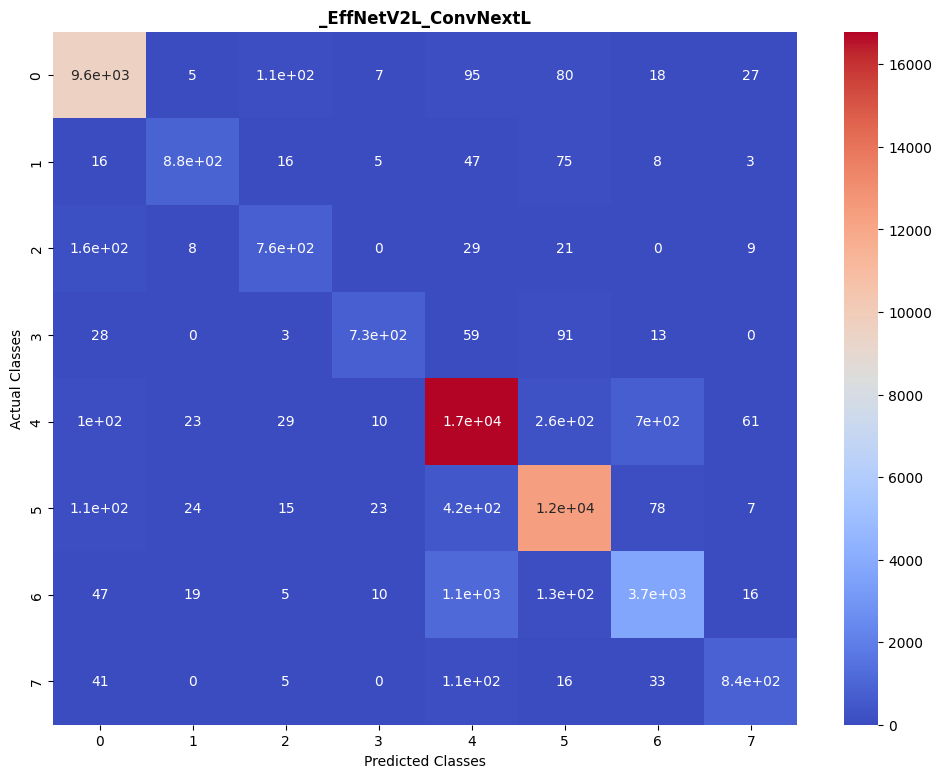

(5,)
[4 4 7 ... 5 4 2]
_ConvNextL
_ConvNextL
The validation accuracy score is: 0.92456


**Classification Report**

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      9935
           1       0.94      0.86      0.90      1049
           2       0.83      0.80      0.81       993
           3       0.95      0.81      0.87       928
           4       0.90      0.95      0.93     17969
           5       0.97      0.94      0.95     13006
           6       0.84      0.79      0.81      5075
           7       0.90      0.85      0.88      1045

    accuracy                           0.92     50000
   macro avg       0.91      0.87      0.89     50000
weighted avg       0.92      0.92      0.92     50000



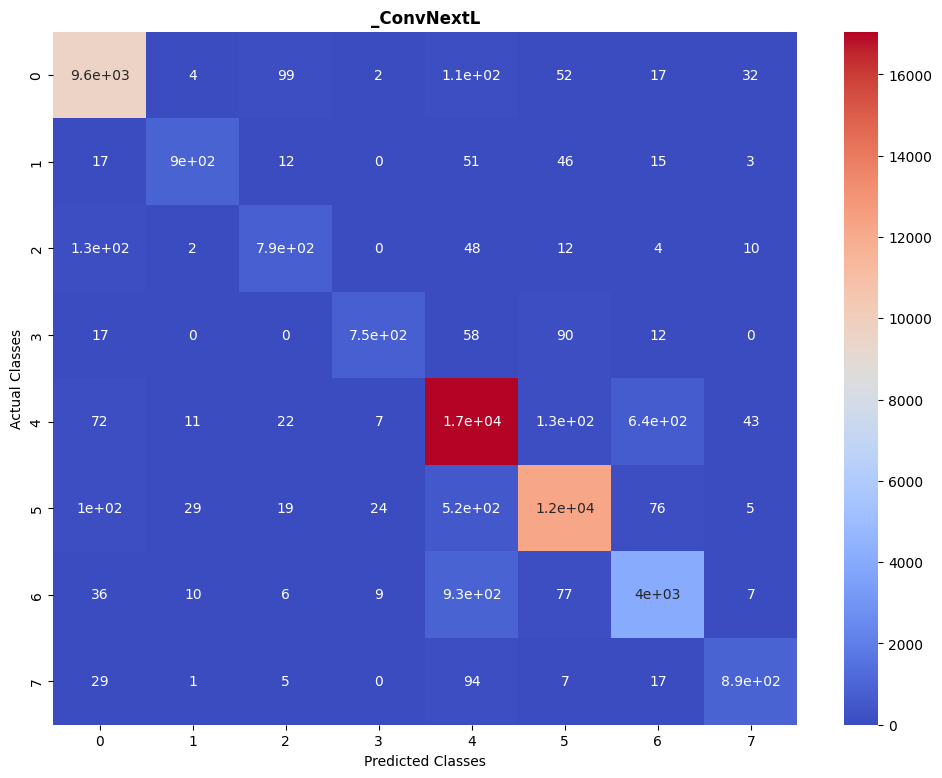

In [ ]:
import time
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score


def Conf_Mat_Val(model_preds, name):
    val_labels = pd.read_csv(root / f"val.csv")
    val_labels = val_labels["coarse"]
    train_score = accuracy_score(val_labels, model_preds)
    print(name)
    print('The validation accuracy score is:', str(train_score))
    display(Markdown('**Classification Report**'))
    print(classification_report(val_labels, model_preds))

    fig, ax = plt.subplots(figsize = (12 , 9))
    DT_Conf_Matrix = confusion_matrix(val_labels, model_preds)
    ax = sns.heatmap(DT_Conf_Matrix, annot = True, cmap='coolwarm')
    ax.set_title(label = name, fontdict = {'fontweight' : 'bold'})
    ax.set_ylabel('Actual Classes')
    ax.set_xlabel('Predicted Classes')
    plt.show()
    return

pred_arrays = [incepV3, incepRNV2, ResNet101V2, Xcep, EffNetV2L, ConvNextL, EffB7, ResNet152V2]
pred_array_names = ['inceptionV3', 'InceptionResNetV2','ResNet101V2', 'Xception', 'EffNetV2L', 'ConvNextL', 'EffB7', 'ResNet152V2']

subs = [(2, 3, 6, 7)]
for sub in subs:
    print(sub)
    name = ""
    for x, combo in enumerate(sub):
        name = name + "_" + pred_array_names[combo]
        if x == 0:
            out_arr = pred_arrays[combo]
        else:
            out_arr = np.add(out_arr, pred_arrays[combo])

mixed = out_arr/4
mix_name = name
print(mixed[0])

subs = [(4, 5), (5,)]
for sub in subs:
    print(sub)
    name = ""
    for x, combo in enumerate(sub):
        name = name + "_" + pred_array_names[combo]
        if x == 0:
            out_arr = pred_arrays[combo]
        else:
            out_arr = np.add(out_arr, pred_arrays[combo])
    preds = np.argmax(out_arr, axis = 1)
    print(preds)
    print(name)
    Conf_Mat_Val(preds, name)

**Code Summary for Above**

- The above code was used to test how the different deep learning models I made could be combined to create a better overall model.
- From the above you can see I tried to combine the other models separately and then combine them with the ConvNext model, however you can see that it does not perform as well.

### Deep Learning Model - Creating, Training and Testing Fine Model

In [ ]:
train_ds = create_dataset_tf_augsV2(root, 'train', fine_grained=fine_grain, batch_size=batch_size)
val_ds = create_dataset_tfV2(root, 'val', fine_grained=fine_grain, batch_size=batch_size)

model = tf.keras.models.load_model('/gdrive/MyDrive/comp8220/ConvNextXLargeV2')

x = model.layers[-2].output

output = tf.keras.layers.Dense(50, activation="softmax")(x)
model = tf.keras.models.Model(inputs=model.input, outputs=output)

model.trainable = True
for layer in model.layers[:-2]:
  layer.trainable =  False

model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.01/10, epsilon = 0.1, weight_decay = 1e-3),
              metrics=["accuracy"])
model.summary()

initial_epochs = 4
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=initial_epochs, callbacks = [aggroCONV_F])

4
1
3
2
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 112, 112, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 112, 112, 3)       0         
                                                                 
 convnext_large (Functional)  (None, 3, 3, 1536)       196230336 
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                   

**Code Summary for Above**

- The above code first grabs the ConvNext trained model, trained during the coarse training portion of this ML task.
- It then removes the softmax output layer and puts a new softmax layer on with the 50 classes.
- Next it freezes all of the layers again, compiles the model and starts the training.

In [ ]:
model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))
fine_tune_at = int(len(model.layers[3].layers)*0.75)
print(fine_tune_at)

model.trainable = True
for layer in model.layers[3].layers[:fine_tune_at]:
  layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.01/10, epsilon = 0.1, weight_decay = 1e-3),
              metrics=["accuracy"])
model.summary()

fine_tune_epochs = 3
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Number of layers in the base model:  7
221
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 112, 112, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 112, 112, 3)       0         
                                                                 
 convnext_large (Functional)  (None, 3, 3, 1536)       196230336 
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                

**Code Summary for Above**

- The above code then unfreezes the top 25% of the layers, like it did during the coarse dataset task. The weights here would already be updated from the base model first loaded in from the Keras website, however more training here will update it from assessing for 8 to 50 class labels.
- I recompile the model and continue its training.

In [ ]:
Save_Preds_Val(model, "ConvNextXLargeV2_FINE", fine_grain)
Save_Preds_Test(model, "ConvNextXLargeV2_FINE", fine_grain)
model.save("/gdrive/MyDrive/comp8220/ConvNextXLargeV2_FINE")

**Code Summary for Above**

- The above code creates the predictions and saves the model just like for the coarse dataset.

### Deep Learning Model - Test Time Functions

#### Deep Learning Model - Test Time Functions - Coarse

In [ ]:
!unzip -q /gdrive/MyDrive/comp8220/living-thing-classification-coarse-private.zip

In [ ]:
!ls -alh privtest_coarse

In [ ]:
priv_path = Path('/content/privtest_coarse')

test_ds = create_dataset_tfV2(priv_path, 'privtest', fine_grained=False, batch_size=batch_size)
test_ds0 = create_dataset_tf_TestTime_augsV1(priv_path,'privtest', False, 0, batch_size=32, image_size=112)
test_ds1 = create_dataset_tf_TestTime_augsV1(priv_path,'privtest', False, 1, batch_size=32, image_size=112)
test_ds4 = create_dataset_tf_TestTime_augsV1(priv_path,'privtest', False, 4, batch_size=32, image_size=112)

model = tf.keras.models.load_model('/gdrive/MyDrive/comp8220/ConvNextXLargeV2_V3_Coarse')
model.summary()

**Code Summary for Above**

- The above code was used when the private dataset was released for the coarse dataset. Like in the public set, the file is unzipped and I look at the file directory.
- The next code block creates the base test dataset, but also 3 copies of the test dataset that have had small image augmentations applied to them.
 - This is so that my model can get 4 attempts at predicting the correct label.

In [ ]:
sets = [test_ds, test_ds0, test_ds1, test_ds4]
for x, s in enumerate(sets):
    pred =  model.predict(s)
    if x == 0:
        out_arr = pred
    else:
        out_arr = np.add(out_arr, pred)

preds = np.argmax(out_arr, axis = 1)
print(preds)
print(np.bincount(preds))
print(preds.shape)

In [ ]:
test_csv = pd.read_csv(priv_path / f"privtest_coarse.csv")
test_csv.loc[:,"coarse"] = preds

test_csv.to_csv('/gdrive/MyDrive/comp8220/44900333_DEEP_COARSE_ConvNextXLarge_V2ARGMAX_wTTA_V3_PRIVATETEST_1LessTTA_AUG.csv', index = False )

**Code Summary for Above**

- The above code blocks use the loaded model to predict the probability of each label in the private test dataset. It then adds up all of the predictions and then selects the highest scoring column for each row.
- The second code block then stores the predictions in the google drive to upload on the Kaggle website.
 - This same code block with slight changes was used for the public dataset.

#### Deep Learning Model - Test Time Functions - Fine

In [ ]:
!unzip -q /gdrive/MyDrive/comp8220/living-thing-classification-fine-private.zip

In [ ]:
!ls -alh privtest_fine

In [ ]:
priv_path = Path('/content/privtest_fine')

test_ds = create_dataset_tfV2(priv_path, 'privtest', fine_grained=True, batch_size=batch_size)
test_ds0 = create_dataset_tf_TestTime_augsV1(priv_path,'privtest', True, 0, batch_size=32, image_size=112)
test_ds1 = create_dataset_tf_TestTime_augsV1(priv_path,'privtest', True, 1, batch_size=32, image_size=112)
test_ds4 = create_dataset_tf_TestTime_augsV1(priv_path,'privtest', True, 4, batch_size=32, image_size=112)

model = tf.keras.models.load_model('/gdrive/MyDrive/comp8220/ConvNextXLargeV2_FINE')
model.summary()

**Code Summary for Above**

- The above code is the same as the previous section of code but changed for the fact that this is the fine dataset and the path is named differently.
- It was also used for the public fine dataset model, and improved the performance by a couple of percentage points.

In [ ]:
sets = [test_ds, test_ds0, test_ds1, test_ds4]
for x, s in enumerate(sets):
    pred =  model.predict(s)
    if x == 0:
        out_arr = pred
    else:
        out_arr = np.add(out_arr, pred)

preds = np.argmax(out_arr, axis = 1)
print(preds)
print(np.bincount(preds))
print(preds.shape)

In [ ]:
test_csv = pd.read_csv(priv_path / f"privtest_fine.csv")
test_csv.loc[:,"fine"] = preds

test_csv.to_csv('/gdrive/MyDrive/comp8220/44900333_DEEP_FINE_ConvNextXLarge_V2ARGMAX_wTTA_PRIVATETEST.csv', index = False )

**Code Summary for Above**

- The code block above is much the same as the previous code for the coarse dataset. Just manually changed for the fine dataset. It was not worth coding this into a function because it is easier just to leave as is.

### Deep Learning Model - Process and Discussion

**Overall Results - Deep Learning**

The deep learning model used after training, comparisons and fine-tuning was the ConvNextLarge model, pre-trained from Keras. This model performed about 5% better than the other models on the validation set, as will be shown in the discussion further below. The model was topped with a global averaging 2D layer, a dropout and a dense softmax layer depending on which task was being completed, either coarse or fine. The final public and private test accuracies have been calculated with test time augmentation, while the validation accuracy has not.

The results for this model are below:
- Coarse:
 - Validation Accuracy: 0.9244 (After 4 epochs - which was used for test set)
 - Public Test Accuracy: 0.93408 (2nd overall) (TTA used here)
 - Private Test Accuracy: 0.93200 (2nd overall) (TTA used here)
- Fine:
 - Validation Accuracy: 0.7683
 - Public Test Accuracy: 0.77314 (1st overall) (TTA used here)
 - Private Test Accuracy: 0.77466 (1st overall) (TTA used here)


The ConvNextLarge models performed similarly between the public and private test datasets, which shows the model was not overfit to the public data sets. When I saved and submitted the results of the model, I only had enough time to fine-tune the model for 2 epochs, which is why it did not score as well as it could have if I had more time to continue training the model. <br>


<br>**Process and Further Discussion - Deep Learning**

When I started creating the deep learning system I had already been working on the conventional models for a fair while and so knew that the classification was quite a difficult task and computing power could be an issue.
- To counter this I upgraded my google colab to be able to use better GPUs, as I wanted to treat this assignment as a professional task, where upgrades like this would be available. I also did this because I wanted to be able to increase the dataset size like I did for the conventional system.
- I also went straight to using pre-trained models from Keras instead of trying to build a system from scratch. I had also read some research that discussed models used on the iNaturalist dataset, so I wanted to see how these performed on the public dataset.

After running some of the Keras pre-trained models (Xception and InceptionResNet) I saw that the models were overfitting quickly on the train dataset.
- Therefore, I changed the train dataset code to create 4 data augmentations during the data grabbing stage of the ML system, so that instead of 100K examples my model would have 500K examples.
 - This decreased the overfitting, but I knew it would still be an issue when unfreezing the layers and re-training some of those layers. Therefore, I added a small dropout layer before prediction. The hope here was that it would reduce the overfitting more because it would dropout 20% of the neurons during training. I also added a data augmentation layer that would do small rotations and random flips during the training, to try to combat overfitting.<br>

<br>**Process and Further Discussion (Coarse Results) - Deep Learning**

Below are some of the accuracy scores of the models on the coarse dataset I tried and I will discuss the various lessons they taught me:
- Xception Model, after 10 Epochs:
 - No Dropout: train_accuracy: 0.9522; val_accuracy: 0.7939
   - Validation accuracy peaked at 7th epoch, and then decreased, overfitting a lot after unfreezing around half of the parameters at the 5th epoch.
 - With 0.2 Dropout: train_accuracy: 0.8316; val_accuracy: 0.8140
   - Model was overfitting a lot less with the dropout. Model peaked validation accuracy at around 82.5 after 25 epochs, kept improving on validation set the whole learning process.
- ResNet101V2 model, after 10 Epochs:
 - No Dropout: train_accuracy: 0.9193; val_accuracy: 0.7723
 - With 0.2 Dropout: train_accuracy: 0.9044; val_accuracy: 0.8273
   - Again, the model improved strongly after adding the dropout layer. It could have more of the model unfrozen during fine-tuning and take longer to overfit. Both models are still obviously overfitting, but the one with dropout improves on the validation set for longer.
- InceptionResNetV2 model, after 10 Epochs:
 - No Dropout: train_accuracy: 0.8255; val_accuracy: 0.7740
 - With 0.2 Dropout: train_accuracy: 0.8374; val_accuracy:: 0.8069
   - This model did not improve accuracy as quickly as the other models with or without dropout. Both models overfit a bit, but they did not really improve that much after 10-20 epochs.<br>

<br>These results were decent when comparing to the public test set results for other peoples' models on the coarse dataset, with a few models scoring around the mid 80s in accuracy. From here I had a decent model structure with the dropout, so I then went on to testing a few other pre-trained models on the coarse dataset, to see if any would perform especially well, otherwise I would work on an ensemble of the models.

- ResNet152V2 model, after 16 Epochs:
 - train_accuracy: 0.9217; val_accuracy: 0.8320
 - This model overfit quickly, so I generated a learning rate scheduler, which I then applied to my other models during their generation. It slowed down the overfitting and scored better on the validation set. However, it still maxes out around 83% accuracy.
- EfficientNetB7 model, after 18 Epochs:
 - train_accuracy: 0.8935; val_accuracy: 0.8466
 - This model performed better than the other models I had at this time. It did not overfit as much as the other models, with the gap between train and validation accuracy being lower than in the other models. Currently though this model cannot be saved in the current version of tensorflow, which causes obvious issues when implementing the model on unseen data.
- EfficientNetV2L;
 - After 3 epochs: train_accuracy: 0.8556; val_accuracy: 0.8636
 - After 5 epochs: train_accuracy: 0.9617; val_accuracy: 0.8670
 - This model performed decently and quickly however after 3 epochs it started to overfit without much improvement on the validation dataset as can be seen above. I tried different levels of dropout and different learning rate schedulers, however none of these helped.
- ConvNeXtLarge;
 - After 2 epochs: train_accuracy: 0.8951; val_accuracy: 0.9160
   - I ran this model initially only a day or two before the final assignment was due, and on a batch size of 32 it took a fair amount of time to run.
 - After 4 epochs: train_accuracy: 0.9113; val_accuracy: 0.9244
   - This is the model I used to predict the public and private test sets. The model is not overfitting yet, so there is obviously still room to keep training the model, I just did not have enough time.<br>

<br>From here I had an obviously best model with the ConvNextLarge model. I tried ensembling the predictions of different combinations of the models which can be seen in the code block under 'Deep Learning Coarse', however none of them performed as well as the ConvNextLarge model by itself. Therefore I created a Test Time Augmentation (TTA) section in the code above, and predicted the model on the real test set, as well as on 3 augmentations of the test set. The predictions from this model were then ensembled and submitted to the Kaggle site.
- The TTA worked well, with the predictions on the public and private test sets being around 1% better than the raw model predictions.<br>


<br>**Process and Further Discussion (Fine Results) - Deep Learning**

For the fine models, I left this quite late as I had been focussed on the coarse dataset and conventional ML model for too long. Therefore, I knew I would have to work with pre-trained models again like I did for the coarse dataset.<br>
<br>Immediately, I went to using the models that I had trained on the coarse dataset, and thought about using these, as the top layers had already been trained on the dataset. Therefore I loaded the ConvNextLarge model, removed the predicting layer and placed a new predicting layer on top.
- I re-froze the layers except for the new softmax dense layer with 50 classes and trained it for 4 epochs.
  - After 4 epochs: train_accuracy: 0.6940; val_accuracy: 0.7238
- From here, I unfroze the top layers and fine-tuned the model.
  - I used a learning rate scheduler here, as when I first did this without it, the model overfit quite dramatically, but with the learning rate scheduler, this overfitting was reduced.
- After 3 more fine-tuning epochs: train_accuracy: 0.8065; val_accuracy: 0.7683
  - This was better than the other models on the public train set at this point in time, which was the 2nd last day of the assignment. It was starting to overfit after the 6th epoch.
- From here I used the same TTA code from the coarse dataset on this model and scored 0.77314 on the public test dataset. <br>

<br>I also tried re-training the ResNet152V2 however this one overfit very quickly, scoring train_accuracy: 0.4975 and val_accuracy: 0.4558 after 4 epochs on the frozen model, and scoring train_accuracy: 0.8222 and val_accuracy: 0.4903 after 4 epochs with the top layers unfrozen.
- Due to time constraints, I decided to just stick with the re-trained ConvNextLarge model as it had outperformed strongly on the 8 class task, so I hoped it would continue outperforming the other models on the 50 class task.
  - This seemed to be justified in the end as at the end of the assignment deadline the fine model scored the best on the public and private test sets.



## Final Discussion - Model Performance and Future Ideas/Improvements

**Overall Results**

Overall the deep learning models performed much better than the conventional models in both the coarse and fine classifying tasks. The deep learning classifier, ConvNextLarge scored a 93% across both public and private test sets on the coarse task, and 77% across both test sets in the fine task. This is a large improvement over the conventional models scoring 60% and 12% on the coarse and fine tasks respectively. The benefits from being able to use pre-trained models, and much more sophisticated models in the deep learning section clearly showed the benefit of these models in such a complex task. It also shows that the deep learning model could handle the class imbalance in the coarse dataset a lot better.<br>

<br> In the Kaggle competition the deep learning model got the 2nd best score on the coarse dataset, and the best score on the fine dataset. This was all down to using the ConvNextLarge model, as the ensemble of the other models was scoring about 6% lower than the ConvNextLarge model by itself. On the private dataset my models performed very similarly to how they did on the public dataset, which is positive and shows the models were not overfit to the public test set.<br>

<br>**Difficulty Areas and Areas for Improvement**

A difficult task for the conventional task was dealing with RAM issues. The memmap array usage helped solve a lot of these issues however it took me a long time to figure this out, so I had less time to test 'fine' models. If I was continuing this task I would work on a few different models for the fine task, and I would also use a random gridsearch to try to optimise the hyperparameters on the fine models.

An area for improvement on the deep learning models, would be re-training some more of the coarse models to be fine models, like I did for the ConvNextLarge and the ResNet152V2. I think the ConvNextLarge would still score the best overall, but if there were more prepared than I could have ensembled them and that may have improved accuracy, when combined with the TTA.

## References

Geron, A. (2023) Ageron/Handson-ML3: A series of Jupyter notebooks that Walk you through the fundamentals of machine learning and deep learning in python using Scikit-learn, keras and tensorflow 2., GitHub. Available at: https://github.com/ageron/handson-ml3 (Accessed: 01 April 2023).